In [ ]:
############
# if you need to restart the kernel:
# (a) run the next 2 cells, AND
# (b) VERY IMPORTANTLY, run the camera length change cell for the setup you want, even if its the one you were alreay on.

# in other words after a kernel restart, you need to run one of the camera length change cells before starting to take data.....
# (b) is to over-write default settings loaded during the initial import, to the actual values you need for today's setup.

In [261]:
%matplotlib notebook

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container {width:95% !important;</style>")) # make jupyter use a decent width of the screen

# this version is currently set to import version 12a (which does gridded angle/position scans)
# if you use it, you must run worksgheets containing the column X_position_grid_list (it won't work on older spreadsheets)
# suggest use "nigel_grid_testing" spreadsheet

#if you want to go back tp previous version that does not to gridded angle/position scans:
# change "from GISAXS_invac_halvies_gss_12a_class" in the line below to "from GISAXS_invac_halvies_gss_12_class"
# swap the comments in the spreadsheet ID string back to the old one
# hit CTRL+S to save this file
# restart kernal and process top two cells. (top two cells need running EVERY time the kernel is restarted)

from GSAXS_invac_class_15a_for_general_use import (GI, BeamCountsTooLow, BeamCountsTooHigh, CountsDontMatchTarget, OmegaError, OmegaAnalysis, 
    OmegaFineAnalysis, Gimme_Omega_Data, Gimme_Height_Data, Gimme_Positioner_Data, Gimme_Height_Data_BS, Gimme_Reflectivity_BS, Fluids_Batch_Control)
from saxs_beamline_library.devices.saxs_redis_signal_conf import gsaxs_slit_centre_y

from saxs_beamline_library.devices.saxs_motors import in_vac, saxs_det, beamstop, fdbck_shutter #, gsaxs
from saxs_beamline_library.devices.hexapod import saxs_hexapod as hxp, Hexapod, CoordSystem
#hxp_z_dial = EpicsSignal('SR13ID01:hxp:c0:m3.DVAL', name='hxp_z_dial')

import numpy as np

from bluesky.plans import count, list_scan, rel_list_scan, grid_scan, rel_grid_scan, scan_nd

from saxs_beamline_library.devices.saxs_motors import in_vac

from functools import partial
from cycler import cycler
from pathlib import Path
from bluesky import Msg
import bluesky.preprocessors as bpp

import saxs_beamline_library.plans.saxs_plan_stubs as sps
import saxs_beamline_library.plans.gapless_plan_stubs as gps
from saxs_beamline_library.plans.saxs_plans import gappy_plan, gapless_plan
from saxs_beamline_library.plans.default_detectors import get_detectors
from saxs_beamline_library.acquisition.saxs_acquire_engine import SAXSAcquire
from saxs_beamline_library.devices.saxs_motors import in_vac, gsaxs, gsaxs_spare
from saxs_beamline_library.devices.saxs_detectors import saxs_detector
from saxs_beamline_library.utils import generic_scan_tools
from saxs_beamline_library.devices.saxs_mcc import usbtemp1

from saxs_beamline_library.devices.saxs_motors import beamstop

from time import sleep


from saxs_beamline_library.devices.saxs_motors import mc8


config_path = "/config/saxs_config.yaml"
sa = SAXSAcquire(config_path)
detectors = get_detectors(config_path) # timeouts come from here

from epics import PV
open_gatevalve_8_request = PV('SR13ID01:GV8_OPEN_CMD.PROC')
gatevalve_8_open_status = PV('SR13ID01:IGV08_OPEN_STS')
file_number = PV('SR13ID01PIL1:cam1:FileNumber_RBV')
frame_number = PV('SR13ID01PIL1:cam1:ArrayCounter_RBV')


gi = GI(configuration = "in_air")
#gi = GI(configuration = "in_vacuum")
gi.fine_y_motor = mc8.a
gi.coarse_y_motor = mc8.a

gi.blade_x = gsaxs_spare.x
gi.blade_y = mc8.d

#humidity = PV('SAXSPIDAQ:S1humidity')
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import RunEngine
bec = BestEffortCallback()
RE = RunEngine({})
RE.subscribe(bec)

from time import time
from saxs_beamline_library.acquisition.energy_change import EnergyChange
ec = EnergyChange()

configuration = in_air
Motors in use are gsaxs.omega for pitch, gsaxs.y for fine_y, gsaxs.y for coarse_y, gsaxs.x for x, and there is no motor in Z


In [237]:
linkam_temp = PV('SR13ID01LINKAM:SAMPLE_TEMP')
linkam_setpoint = PV ('SR13ID01LINKAM:TARGET_TEMP')
linkam_go_baby = PV('SR13ID01LINKAM:ACTUATE_CONTROLLER')
linkam_stop = PV('SR13ID01LINKAM:STOP_CONTROLLER')
linkam_ramp_rate = PV('SR13ID01LINKAM:RAMP_RATE')
linkam_dwell_time = PV('SR13ID01LINKAM:DWELL_TIME')
linkam_remaining_dwell_time = PV('SR13ID01LINKAM:REMAINING_DWELL_TIME')
linkam_done = PV("SR13ID01LINKAM:DONE_CONTROLLER")

# SR13ID01LINKAM:SAMPLE_TEMP
# SR13ID01LINKAM:TARGET_TEMP
# SR13ID01LINKAM:ACTUATE_CONTROLLER
# SR13ID01LINKAM:DONE_CONTROLLER
# SR13ID01LINKAM:STOP_CONTROLLER
# SR13ID01LINKAM:RAMP_RATE
# SR13ID01LINKAM:DWELL_TIME
# SR13ID01LINKAM:REMAINING_DWELL_TIME


In [ ]:
gi.coarse_y_motor.position

In [ ]:
linkam_setpoint.put(30)

In [ ]:
saxs_detector.nu

In [ ]:
gi.coarse_y_motor

In [262]:
######### GIWAXS  Settings for in air ##########################
##############################################

# note, for GIWAXS, BS rotation is ~270, for GIWAXS is about 90. set on motor not in python code.
# for multisample_stack (ex-situ):

# Alignment
gi.align_transmission = 0.00002
gi.align_slit_x_width = 0.1
gi.align_slit_y_width = 0.1

gi.align_beam_center = [1422,1644] #initial position


gi.align_det_pos = [130, 53.6] #initial position
gi.align_bs_x_pos = -50.9 # for 342    
gi.safe_bs_pos = [gi.align_bs_x_pos, -19] # for 342     # ******

beamstop_rotation_setting = 89.5

gi.align_coarse_omega_range = [-2,2]
gi.align_coarse_omega_points = 51



# ##########################################
# # Acquire
gi.beamstop_height = -32 # this is actually what gets used for scans because goes into scan_that_thang as attibute. use for GIWAXS.

gi.acquire_slit_x_width = 1
gi.acquire_slit_y_width = 0.3

#WIDE Q RANGE @ 15 keV
gi.acquire_det_x = 150.0

#gi.acquire_det_y = 51.7   
#gi.acquire_det_y = 53.6 #GiWAXS
#gi.acquire_det_y = 58.76 # GiWAXS_Shift  
gi.acquire_det_y = 38.00 # GiWAXS_BC2 ### with beamstop in lowest gap

gi.acquire_bs_pos = [gi.align_bs_x_pos, gi.beamstop_height]

####### settings for feedback tuning for 20 keV
gi.align_fdbk_nominal_exptime.put(0.08)
gi.align_fdbk_nominal_gain.put(10)

In [4]:
from saxs_beamline_library.devices.saxs_motors import gsaxs_spare
gsaxs_spare.x.position

35.499608125979776

In [ ]:
gi.max_sample_thickness = 2

In [ ]:
#for dector offset 
gi.setup_for_acquisition()

In [263]:
gi.setup_for_alignment()

Setting up for Alignment
Final feedback results for setup_for_acquire were [200.57, 200.02, 215, 0.08, 10.0]
Finished Setting up for Alignment


[200.57, 200.02, 215, 0.08, 10.0]

In [ ]:
gi.slit_scan_centre(-0.2, 0.2, 41)


In [ ]:
(1586-1466) * .172

In [ ]:
RE.abort()

In [ ]:
gi.sample_z_displacement_deadband = 1000

In [ ]:
gi.control_sample_z_displacement

In [ ]:
gi.blade_x.limits
desired_x_pos

In [ ]:
gi.blade_y.limits


In [ ]:
ylim_low, ylim_high = gi.blade_y.limits
ylim_high > 12 > ylim_low

In [ ]:
# just do fast height alingment
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, skip_coarse_omega = True, skip_fine_omega = True, reset_omega = False, 
                                          setup_for_acquisition_after_align = True)

In [ ]:
# fast height-only alignment
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False,  skip_coarse_omega = True, skip_fine_omega = True,                                    
                                          reset_omega = False,
                                          setup_for_acquisition_after_align = True)

In [ ]:
#     def scan_that_thang(self, scan_filename, setup=True, use_shutter = False, user_gapless = True, user_shutter = False, exposure_time = 1.0):
#         self.table3(filename=scan_filename,
#                image_path=None,
#                exp_time=exposure_time,
#                num_images = 1,
#                motor1 = self.pitch_motor,
#                points1 = self.acquire_angles,
#                motor2 = self.x_motor,
#                points2 = [self.x_motor.position + i for i in self.X_position_relative_list],    # this makes it absolute from relative input
#                motor3 = beamstop.y,
#                points3 = self.beamstop_positions,
#                filename_device = saxs_detector.file_name,
#               #filenames = [scan_filename for a in acquire_angles])
#                filenames = [f'{scan_filename}_{a}'.replace('.', 'p') for a in self.acquire_angles],
#                gapless = user_gapless,
#                #gapless = True,
#                use_feedback = 1,
#                #use_shutter = False,
#                use_shutter = user_shutter
#               )

In [ ]:
gi.acquire_angles=[0.1,0.2]
gi.scan_that_thang('my_file_name')

In [ ]:
gi.acquire_angles

In [6]:
#################################################### RUN THIS CELL FIRST  ################
# things to set during routine acquisition, and display spreadsheet (without running it)
#gi.align_fdbk_nominal_exptime = 0.05
#gi.align_fdbk_nominal_gain = 5
#
# -------------------- LOAD THIS FIRST FOR SPREADSHEET ------------------------------------------
#
gi.spreadsheet_key = '18dW6IP9_lp7cT29iuHfI9yyClVmWqxfLwWs8Vmp2MM4'

gi.wks_name = 'sheet_4'

gi.max_sample_thickness = 2   #### DON'T FORGET TO CORRECT SAMPLE THICKNESS


gi.align_coarse_omega_range = [-1,1]
gi.align_coarse_omega_points = 41

# display the spreadsheet (but don't run it)

gi.per_sample_repeats = 0   #Repeats on top of initial angle scan
gi.loop_wait_time = 60      #waiting time in seconds between angle scan repeats
gi.loop_x_offset  = 0    #wposition offset of loop from original starting x-position (mm)

#gi.beamstop_height = 9

gi.load_process_spreadsheet()

,Sample_name,Skip_sample,Sample_length,Sample_holder,X_position,Skip_alignment,Skip_coarse_omega,Skip_fine_omega,hxp_offset,Exposure_time,angles,X_position_grid_list,Repeat_angle_list,x_per_shot_offset,Second_camera_length,User_label,(User notes - Final X)
0,X9_01,0,14.0,1,-54.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
1,X9_02,0,14.0,1,-42.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
2,Q9_01,0,12.0,1,-25.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
3,X3_01,0,12.0,1,-12.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
4,X3_02,0,10.0,1,-1.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
5,X3_04,0,10.0,1,10.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
6,X3_05,0,11.0,1,21.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
7,X8_02r,0,14.0,1,35.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,


In [ ]:
###################################### RUN THIS CEL AFTERWARDS  #########################################
# RUN ALL THE RELEVANT SAMPLES IN THE SPREADSHEET
# use "Abort batch" toggle on "Top Level Experiment Screen" GUI to stop a batch - it will finish the current sample and then exit the batch nicely.

# HAVE YOU MOVED THE BLADE AWAY FOR SPREADSHEET RUN???

gi.blade_y.set(22, wait=True)
gi.reset_batch_controls()
gi.run_samples_from_spreadsheet()

# run samples

In [ ]:
###################################### RUN THIS CEL AFTERWARDS  #########################################
# RUN ALL THE RELEVANT SAMPLES IN THE SPREADSHEET
# use "Abort batch" toggle on "Top Level Experiment Screen" GUI to stop a batch - it will finish the current sample and then exit the batch nicely.
gi.reset_batch_controls()
gi.run_samples_from_spreadsheet()

# run samples

In [ ]:
#############################################################################################################
### 00 STOP COMMANDS!
#############################################################################################################
sa.abort()
RE.abort()


In [7]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AT THE BEAM POSITION
#############################################################################################################

def rule_the_world():
    
    #get staring stuff
    starting_blade_x_velocity = gi.blade_x.velocity.get()
    starting_blade_y_velocity = gi.blade_y.velocity.get()
    starting_blade_x_position = gi.blade_x.position
    starting_blade_y_position = gi.blade_y.position
    
    # Choose the rules of the world
    desired_y_vel = 2 #mm/s
    desired_x_vel = 5 #mm/s
    desired_y_pos = starting_blade_y_position + 10
    desired_x_pos = starting_blade_x_position + 70
    
    # Check limits
    ylim_low, ylim_high = gi.blade_y.limits
    assert (ylim_low < desired_y_pos) and (desired_y_pos < ylim_high), "High limit for Y!"
    xlim_low, xlim_high = gi.blade_x.limits
    assert (xlim_low < desired_x_pos) and (desired_x_pos < xlim_high), "High limit for X!"

    # Set the velocities to move
    gi.blade_x.velocity.put(desired_x_vel)
    gi.blade_y.velocity.put(desired_y_vel)
    
    # Move
    gi.blade_y.set(desired_y_pos, wait=True)
    gi.blade_x.set(desired_x_pos, wait=True)
    
#     e = None
#     try:
    # Run the alingment
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
    
#     except Exception as e:
#         pass
    
    # Return the blade at a slow velocity
#     gi.blade_y.velocity.put(2)
    gi.blade_x.set(starting_blade_x_position, wait=True)
    gi.blade_y.set(starting_blade_y_position, wait=True)
    
    # Return the velocities
    gi.blade_x.velocity.put(starting_blade_x_velocity)
    gi.blade_y.velocity.put(starting_blade_y_velocity)
    
#     if e:
#         raise e
    
rule_the_world()

Starting Alignment
Setting up for Alignment
Feedback camera tuning successful.


KeyboardInterrupt: 

In [ ]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [ ]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='test_angles'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [5]:
def move_blade_and_sample(offset, speed=0.4, wait=False):
    # Positive offset is towards the user cabin, negative offset away.
    if speed >= 2:
        raise ValueError(f"{speed} mm/s too fast. limit 2.")
    else:
        # Collect initial velocities
        ini_bl_vx = gi.blade_x.velocity.get()
        ini_sm_vx = gsaxs.x.velocity.get()
        
        # Set new velocities
        gi.blade_x.velocity.put(speed)
        gsaxs.x.velocity.put(speed)

        # CHOSE SIGN CAREFULLY.
        gi.blade_x.set(gi.blade_x.position + offset, wait=False)
        gsaxs.x.set(gsaxs.x.position + offset, wait=wait)
        
        # Return velocities.
        gi.blade_x.velocity.put(ini_bl_vx)
        gsaxs.x.velocity.put(ini_sm_vx)
        

In [ ]:
#############################################################################################################
### Move the blade and sample at the same same time with the same speed - to adjust the initial position!
#############################################################################################################

# Test it here
move_blade_and_sample(5,1)

In [16]:
#############################################################################################################
### Create the single shot fast function! and import required libraries.
#############################################################################################################
import pandas as pd
import time
import os
def fast_GI_scan_single_shot(filename, exposure_time):
    # Still takes about 2s overhead due to shutter opening closing if you keep shooting single shots.
        per_shot = sps.per_step_with_shutter_video_count
        inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
        plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(filename),
                       exp_time=exposure_time,
                       num_images_per_trigger=1,
                       use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                       open_shutter=True)

        sa.queue({"type": "plan", "data": plan}, wait=True)
        
def fast_GI_scan_multi_shot(filename, exposure_time, number_shots):
        per_shot = sps.per_step_with_shutter_video_count
        inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
        plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(filename),
                       exp_time=exposure_time,
                       num_images_per_trigger=number_shots,
                       use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                       open_shutter=False)

        sa.queue({"type": "plan", "data": plan}, wait=False)
        
# file_number = PV('SR13ID01PIL1:cam1:FileNumber_RBV') # Indicates the next filenumber to save (not previous!)
# frame_number = PV('SR13ID01PIL1:cam1:ArrayCounter_RBV') # Indicates the current frame measured by the detector --> 0 is running, 1 is 1st done and 2nd running etc. 

In [ ]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

In [ ]:
#############################################################################################################
# Run a blade!!!!! - without Gating
# -> Make sure you have the initial position on the water meniscus attached to the blade, near the right edge of the sample.
# -> This program will `dry_offset` to a position to measure the dry film, before introducing water for 5 minutes, before running the acquisition scan.
# -> You should know the critical angle already.
# -> You should have the sample aligned already.
#############################################################################################################
sample_name = "Q5_01_r01"
angle_of_incidence = 0.095
mensicus_width = 3 # what is the space I can measure accross -> determines measurement total time.
dry_offset = -8 #mm #must be negative to move beam spot to the left of the water.
time_soak = 60*5 #seconds 60*5
stage_speed = 0.1 #mm/s (maximum is 2)
blade_speed = 0.45 #mm/s
sample_movement = - mensicus_width #mm, relative to initial position.
blade_movement = 7 #mm, relative to initial position.
measurement_time = 0.1 # time per shot.

# Limits
assert stage_speed < 2, "Maximum is 2"
assert sample_movement <= 0, "Sample stage movement in the -ve direction is negative."
time_delta1 = abs(sample_movement)/abs(stage_speed)
time_delta2 = abs(blade_movement)/abs(blade_speed)
time_detla = time_delta1 if time_delta1 > time_delta2 else time_delta2
# Calculate number of shots and start shooting
num_shots = int((time_detla) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# First move the sample to a dry spot `dry_offset` mm away.
assert dry_offset < 0
# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4)
time.sleep(abs(dry_offset) / 0.4) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-time_soak],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

# Move the blade so the water sits on the current position for 5 minutes.
gi.blade_x.velocity.put(blade_speed)
print("Moving to wet position")
gi.blade_x.set(gi.blade_x.position - dry_offset, wait=True)
print(f"Move complete, waiting for {time_soak - 5 if time_soak > 5 else 0}s")
time.sleep(time_soak - 5 if time_soak > 5 else 0)
print("Soak complete. Running measurement in 5s.")
time.sleep(5)

# Run an initial scan
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# Start shooting
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

# Start the movement of the motors after initializing the camera.
## Blade
final_blade_x = init_blade_x + blade_movement
gi.blade_x.set(final_blade_x, wait=False)
## Stage
final_sample_x = init_sample_x + sample_movement
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()
for i in range(num_shots):
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    
# Wait for some time after measurement... fully dry?
time.sleep(30)

# TAKE ONE LAST IMAGE another 10s later for clarity on what's been measured.
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
df


In [ ]:
# Manually Save the data to file
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the data frame

csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
df

In [ ]:
#############################################################################################################
# Reset to the initial blade / sample positions! WARNING - MIGHT DESTROY YOUR SAMPLE WITH LIQUID MOVEMENT?
#############################################################################################################
gsaxs.x.set(init_sample_x, wait=False)
gi.blade_x.set(init_blade_x, wait=False)


In [6]:
# Import the necessary libraries to run the Agilent SMU libraries.
import threading
import time
import matplotlib.pyplot as plt
from McNeill_23899_2025_InAir_GatingControl import AgilentB2902A

#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [ ]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [ ]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='M2_15_r01'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [ ]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

In [ ]:
#############################################################################################################
############################# # Run a blade!!!!! - WITH Gating BE CAREFULLLLLL############################## 

# IS THIS THE ONE???!?1/1/1/1/1/1/1
# -> Make sure you have the initial position on the water meniscus attached to the blade, near the right edge of the sample.
# -> This program will `dry_offset` to a position to measure the dry film, before introducing water for 5 minutes, before running the acquisition scan.
# -> You should know the critical angle already.
# -> You should have the sample aligned already.
#############################################################################################################
sample_name = "M2_15_r01"
angle_of_incidence = 0.105
voltage = 0 # Voltage is the blade, Sample is grounded
mensicus_width = 3 # what is the space I can measure accross -> determines measurement total time.
dry_offset = -7 #mm #must be negative to move beam spot to the left of the water. 1mm travel less
time_soak = 15 #seconds 60*5
stage_speed = 0.1 #mm/s (maximum is 2)
blade_speed = 0.45 #mm/s
sample_movement = - mensicus_width #mm, relative to initial position.
blade_movement = 5 #mm, relative to initial position. 2mm travel less
measurement_time = 0.1 # time per shot.


# Limits
assert stage_speed < 2, "Maximum is 2"
assert sample_movement <= 0, "Sample stage movement in the -ve direction is negative."
assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "
time_delta1 = abs(sample_movement)/abs(stage_speed)
time_delta2 = abs(blade_movement)/abs(blade_speed)
time_detla = time_delta1 if time_delta1 > time_delta2 else time_delta2
# Calculate number of shots and start shooting
num_shots = int((time_detla) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)
# Setup the gate
inst = AgilentB2902A()
inst.setup()


# First move the sample to a dry spot `dry_offset` mm away.
assert dry_offset < 0
# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4)
time.sleep(abs(dry_offset) / 0.4) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-time_soak],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

# Move the blade so the water sits on the current position for 5 minutes.
gi.blade_x.velocity.put(blade_speed)
print("Moving to wet position")
gi.blade_x.set(gi.blade_x.position - dry_offset, wait=True)
print(f"Move complete, waiting for {time_soak - 5 if time_soak > 5 else 0}s")
# Setup the gating
new_thread = threading.Thread(target=inst.run_measurement, args=(
    #turn_on_time,  turn_on_voltage, turn_off_time_meas, turn_off_voltage=0, meas_interval=0.005
    1,              voltage,            1,                   0,                  0.050
))
new_thread.start()
time.sleep(1)
print("Turned on gate!")


time.sleep(time_soak - 5 if time_soak > 5 else 0)
print("Soak complete. Running measurement in 5s.")
time.sleep(5)

# Run an initial scan
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# Start shooting
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

# Start the movement of the motors after initializing the camera.
## Blade
final_blade_x = init_blade_x + blade_movement
gi.blade_x.set(final_blade_x, wait=False)
## Stage
final_sample_x = init_sample_x + sample_movement
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()
for i in range(num_shots):
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    
# Wait for some time after measurement... fully dry?
time.sleep(3)
print("Stopping the gate...")
inst.stoptrigger = True
new_thread.join()

print("Turned off the gate.")


# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
print("Taking final `dry` shot after 30s")
time.sleep(30)
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)
print("Finished")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
            "blade_voltage (V)" : voltage,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the gating data
gating_data = inst.datapoints
gating_data[:,0] -= start_time # adjust the gating timestamps to be the same offset as the rest of the data.
gating_name = save_filename + "_gating.txt"
if not os.path.exists(gating_name):
    with open(gating_name, "w") as gatingfile:
            gatingfile.write("Time (s)\tVoltage\tCurrent\n")
            np.savetxt(gatingfile, gating_data)
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
        
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
inst.close()
    
df


In [ ]:
# plot the data
times = gating_data[:, 0]
current = gating_data[:, 1]
voltage = gating_data[:, 2]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], current[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], label='Current (A)', marker="x", linewidth=0.5)
ax1.set_ylabel('Current (A)')
ax1.legend()
ax2.plot(times[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], voltage[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], label='Voltage (V)', color='orange')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Voltage (V)')
ax2.legend()
plt.ylim(-1, 2)
plt.show()

In [ ]:
#############################################################################################################
### Move the blade and sample at the same same time with the same speed - to adjust the initial position!
#############################################################################################################

# Test it here
move_blade_and_sample(7.8753,1)

In [273]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.15, 199.08, 213, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function


KeyboardInterrupt: 

In [ ]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='M2_01_angles'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [ ]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

In [ ]:
# Reset x speeds to 1.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

In [ ]:
t_coating, t_coating* 9

In [ ]:
###############################################################################################################
# Xu's FAST Blade Coating, No Gating, Huzzah!
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is 2mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################

# sample_name = "X1_01_r01"
sample_name = "Xu_test7_fast_coat"
angle_of_incidence = 0.095
sample_width = 34 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 0.3 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -7 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring = 35
# The Blade coating speeds
blade_velocity = 7 #mm/s
stage_velocity_with_blade = -2 #mm/s (maximum is 2)

# Limits
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0
assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "

# Calculate the time taken for the blade to reach the final 5mm of the sample
t_coating = (sample_width - initial_blade_offset_from_right_edge - 5) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 7 # 7 is 5mm blade final position + 2mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas}.")
# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating))
assert stage_speed_after_coat > 0.05, f"The measurement coating speed is {stage_speed_after_coat}, should be >=0.05 mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)

# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4) # Move -5 mm for the meniscus, and -2mm for a dry offset!
                          
time.sleep(abs(dry_offset) / 0.4 + 1) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-5],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

print("Measured the dry point. Starting full measurement in...\n5 s ...")
time.sleep(1)
print("4 s ...")
time.sleep(1)
print("3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")
# Start the blade coating!
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)


## Calculate movement of motors for the coating
final_blade_x = init_blade_x + (blade_velocity * t_coating)
final_sample_x = init_sample_x + (stage_velocity_with_blade * t_coating)

# Start shooting
print("Starting fast image acquisition and moving sample...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

#### Start the movement of the motors after initializing the camera.
## Set
gi.blade_x.set(final_blade_x, wait=False)
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()

coating_finished = False
prev_shot_number = f2_num
meas_stage_x = None
meas_blade_x = None
i_coat = None
d1s=[]
d2s=[]
for i in range(num_shots):
    # Ensure we're up to the right scan number.
    if prev_shot_number == -1:
        if i != f2_num:
            continue
        else:
            prev_shot_number = f2_num
    
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        if (f2_num > i) and (f2_num != prev_shot_number):
            # The counts have already gone ahead... skip to the correct i.
            prev_shot_number = -1 # Set this as a flag to continue until the correct.
            break
    if prev_shot_number == -1:
        continue
    
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
                          
    # Set the movement of the stage if the coating is finished
    d1 = abs(final_sample_x - gsaxs.x.position)
    d2 = abs(final_blade_x - gi.blade_x.position)
    d1s.append(d1)
    d2s.append(d2)
    if (not coating_finished) and (d1 < 0.01) and (d2 < 0.01):
        coating_finished = True
        
        ## move the sample and the blade forwards
        #speeds
        gi.blade_x.velocity.put(stage_speed_after_coat, wait=True)
        gsaxs.x.velocity.put(stage_speed_after_coat, wait=True)
        
        #Set the new values to current values plus the delta
#         gsaxs.x.set(gsaxs.x.position - x_meas, wait=False) 
#         gi.blade_x.set(gi.blade_x.position - x_meas, wait=False)
        
        # Calculate the positions of the motors for the scan numbers.
        N = num_shots - i
        deltas = np.linspace(0, -x_meas, N)
        
        i_coat = i
        meas_sample_x = gsaxs.x.position + deltas
        meas_blade_x = gi.blade_x.position + deltas
        
        gsaxs.x.set(meas_sample_x[0], wait=False) 
        gi.blade_x.set(meas_blade_x[0], wait=False)
        
    elif coating_finished:
        # Keep moving the position as the detector catches up time wise with delays.
        gsaxs.x.set(meas_sample_x[i-i_coat], wait=False) 
        gi.blade_x.set(meas_blade_x[i-i_coat], wait=False)
    

print("Fast measurement completed.")
plt.plot(d1)
plt.plot(d2)
plt.show()

# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
print("Taking final `dry` shot after 30s")
time.sleep(30)
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)
print("Finished")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
            "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
            "blade_speed (mm/s)": blade_velocity,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "dry_offset (mm)" : dry_offset,
            "initial_blade_offset_from_right_edge (mm)": initial_blade_offset_from_right_edge,
            "measurement_time (s)": time_measuring,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

df


In [ ]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AT THE BEAM POSITION
#############################################################################################################
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
def rule_the_world_new():
    
    #get staring stuff
    starting_blade_x_velocity = gi.blade_x.velocity.get()
    starting_blade_y_velocity = gi.blade_y.velocity.get()
    starting_stage_x_velocity = gsaxs.x.velocity.get()
    starting_blade_x_position = gi.blade_x.position
    starting_blade_y_position = gi.blade_y.position
    starting_stage_x_position = gsaxs.x.position
    
    # Choose the rules of the world
    desired_y_vel = 2 #mm/s
    desired_x_vel = 5 #mm/s
    desired_x_vel_stage = 2 #mm/s
    dry_offset = (sample_width-2)/2
    desired_y_pos = starting_blade_y_position + 10
    desired_x_pos = starting_blade_x_position + 10
    desired_x_pos_blade = starting_stage_x_position - dry_offset
    
    # Check limits
    ylim_low, ylim_high = gi.blade_y.limits
    assert (ylim_low < desired_y_pos) and (desired_y_pos < ylim_high), "High limit for Y!"
    xlim_low, xlim_high = gi.blade_x.limits
    assert (xlim_low < desired_x_pos) and (desired_x_pos < xlim_high), "High limit for X!"

    # Set the velocities to move
    gi.blade_x.velocity.put(desired_x_vel)
    gi.blade_y.velocity.put(desired_y_vel)
    gsaxs.x.velocity.put(desired_x_vel_stage)
    
    # Move
    gi.blade_y.set(desired_y_pos, wait=True)
    gi.blade_x.set(desired_x_pos, wait=True)
    gsaxs.x.set(desired_x_pos_blade, wait=True)
    
#     e = None
#     try:
    # Run the alingment
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
    
#     except Exception as e:
#         pass
    
    # Return the blade at a slow velocity
#     gi.blade_y.velocity.put(2)
    gi.blade_x.set(starting_blade_x_position, wait=True)
    gi.blade_y.set(starting_blade_y_position, wait=True)
    gsaxs.x.set(starting_stage_x_position, wait = True)
    
    # Return the velocities
    gi.blade_x.velocity.put(starting_blade_x_velocity)
    gi.blade_y.velocity.put(starting_blade_y_velocity)
    gsaxs.x.velocity.put(starting_stage_x_velocity)
    
#     if e:
#         raise e
    
rule_the_world_new()

In [ ]:
# the two thermocouples:
usbtemp1.t1.get() # is the one near the outboard edge of the sample
usbtemp1.t2.get() # is the one near the centre of the sample

In [ ]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [ ]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
import pandas as pd, numpy as np, matplotlib.pyplot as plt
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

In [ ]:
# # Xu's FAST Blade Coating, No Gating, Huzzah! MODIFIED W/O MATT.
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is 2mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
import time  

sample_name = "X1_10_r04"
angle_of_incidence = 0.1
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 0.6 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -7 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring = 330 # 8 mins
# The Blade coating speeds
blade_velocity = 7 #mm/s
stage_velocity_with_blade = -2 #mm/s (maximum is 2)
post_measurement_image_intervals = [30, 30, 30] # The times to consecutively wait and take extra gapless images after the main fast sequence.
post_measurement_angle_scan_interval = 30 #consecutive time to wait for angle scan


assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "

# Limits
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0

# Calculate the time taken for the blade to reach the final 5mm of the sample
t_coating = (sample_width - initial_blade_offset_from_right_edge - 5) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 9 # 9 is 5mm blade final position + 4mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas}.")
# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating)) * 0.5 # Add an extra factor to reduce speed as the detector has some delay in image taking.
assert stage_speed_after_coat > 0.015, f"The measurement coating speed is {stage_speed_after_coat}, should be >=0.05 mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)

# move to dry spot!!
move_blade_and_sample(dry_offset, 1.99) # Move -5 mm for the meniscus, and -2mm for a dry offset!
                          
time.sleep(abs(dry_offset) / 1.99 + 1) # Wait for movement to finish.

# Save the information
if safety_measurement:
   data = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "blade_x (mm)" : [],
       "sample_x (mm)" : [],
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")

#print("Measured the dry point.") 
print(" Starting full measurement in...\n5 s ...")
time.sleep(1)
print("4 s ...")
time.sleep(1)
print("3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")
# Start the blade coating!
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

print(f"stage velocity {gsaxs.x.velocity}")
# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(abs(stage_velocity_with_blade))


#print(f"blade velocity {gi.blade_x.velocity}")
print(f"stage velocity {gsaxs.x.velocity}")

## Calculate movement of motors for the coating
final_blade_x = init_blade_x + (blade_velocity * t_coating)
final_sample_x = init_sample_x + (stage_velocity_with_blade * t_coating)

# Start shooting
print("Starting fast image acquisition and moving sample...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

time.sleep(6)

#### Start the movement of the motors after initializing the camera.
## Set
gi.blade_x.set(final_blade_x, wait=False)
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 

coating_finished = False
meas_stage_x = None
meas_blade_x = None
i_coat = None
d1s=[]
d2s=[]
pos1=[]
pos2=[]
times=[]

changing_frame = False # Have we changed frame number yet? at all? 
initial_f2_num = f2_num
for i in range(num_shots):
    # Get the current frame number.
    f2_num = frame_number.get() # Get the current number.
    t = time.time()
    
    # Are we changing frames yet?
    while not changing_frame:
        f2_num = frame_number.get() # Get the current number.
        if f2_num != initial_f2_num:
            changing_frame = True
        time.sleep(0.01)
    
    # Skip to current frame
    if i <= f2_num:
        print(f"Missed frame {i}, skipping record")
        continue
        
    while f2_num != i:
        time.sleep(0.01)
        f2_num = frame_number.get() # Get the current number.
        
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num) #
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
                          
    # Set the movement of the stage if the coating is finished
    d1 = abs(final_sample_x - gsaxs.x.position)
    d2 = abs(final_blade_x - gi.blade_x.position)
    d1s.append(d1)
    d2s.append(d2)
    pos1.append(gsaxs.x.position)
    pos2.append(gi.blade_x.position)
    times.append(time.time())
    
    # Have we finished coating? Do a check, calculate the translation required.
    if (not coating_finished) and (d1 < 0.01) and (d2 < 0.01):
        print(f"end position reached with d1={d1} and d2={d2}, i={i}")
        coating_finished = True
        
        ## move the sample and the blade forwards
        #speeds
        gi.blade_x.velocity.put(stage_speed_after_coat, wait=True)
        gsaxs.x.velocity.put(stage_speed_after_coat, wait=True)
        
        #print(f"blade velocity {gi.blade_x.velocity}")
        #print(f"stage velocity {gsaxs.x.velocity}")
        
        #Set the new values to current values plus the delta
        gsaxs.x.set(gsaxs.x.position - x_meas, wait=False) 
        gi.blade_x.set(gi.blade_x.position - x_meas, wait=False)
        
#         # Calculate the positions of the motors for the scan numbers.
#         N = num_shots - i
#         deltas = np.linspace(0, -x_meas, N)
        
#         i_coat = i
#         meas_sample_x = gsaxs.x.position + deltas
#         meas_blade_x = gi.blade_x.position + deltas
        
#         gsaxs.x.set(meas_sample_x[0], wait=False) 
#         gi.blade_x.set(meas_blade_x[0], wait=False)
        
    # We have finished coating! Use the calculated steps to move.
#     elif coating_finished:
#         # Keep moving the position as the detector catches up time wise with delays.
#         gsaxs.x.set(meas_sample_x[i-i_coat], wait=False) 
#         gi.blade_x.set(meas_blade_x[i-i_coat], wait=False)
    

print("Fast measurement completed.")

# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
post_time = 0
for post_time_offset in post_measurement_image_intervals:
    # Accumulate
    post_time += post_time_offset
    
    # Measure
    print(f"Taking `dry` shot after {post_time}s")
    time.sleep(post_time_offset)
    angles = [angle_of_incidence]
    gi.acquire_angles = angles
    gi.X_position_relative_list = [-0.05] * len(angles)
    gi.beamstop_positions = [gi.beamstop_height] * len(angles)
    f_num = file_number.get()

    fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
    gi.scan_that_thang(scan_filename=sample_name + f"_post_{post_time}s", setup=False, exposure_time=1.0)
    f2_num = frame_number.get()
    data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(gi.blade_x.position)
    data["sample_x (mm)"].append(gsaxs.x.position)


#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
            "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
            "blade_speed (mm/s)": blade_velocity,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "dry_offset (mm)" : dry_offset,
            "initial_blade_offset_from_right_edge (mm)": initial_blade_offset_from_right_edge,
            "measurement_time (s)": time_measuring,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################
post_time += post_measurement_angle_scan_interval
print(f"Taking `dry` incident angle scan after {post_time} s")
time.sleep(post_measurement_angle_scan_interval)
print("Finished waiting final shot...")
scan_filename=f'{sample_name}_post_{post_time}s_angle_scan'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

print

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)



times=np.array(times)
d1s=np.array(d1s)
d2s=np.array(d2s)
fig,ax = plt.subplots()
ax.plot(times-times[0],d1s,label="sample")
ax.plot(times-times[0],d2s,label="blade")
plt.legend()
plt.show()

pos1=np.array(pos1)
pos2=np.array(pos2)
fig,ax = plt.subplots()
ax.plot(times-times[0],pos1,label="sample")
ax.plot(times-times[0],pos2,label="blade")
plt.legend()
plt.show()


    
df


In [ ]:
gi.setup_for_acquisition()

In [ ]:
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)
f2_num, frame_number.get(), i


In [ ]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='X01_09_r01_angle_scan2'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [ ]:
temps = np.linspace(25, 350, 27)
temps = np.r_[temps, temps[25::-1]]
temps

In [ ]:
# fast height-only alignment
# temps = np.linspace(25, 350, 14)
temps = np.linspace(25, 350, 27)
temps = np.r_[temps, temps[25::-1]]
linkam_ramp_rate.put(10) #Degrees per minute.
linkam_dwell_time.put(60) #60 seconds to stabilise.

setpoint = []
linkam_rb = []
usb_temps1 = []
usb_temps2 = []
stage_y = []

for temp in temps:
    # Set the temperature setpoint and go
    linkam_setpoint.put(temp)
    linkam_dwell_time.put(60) #60 seconds to stabilise.
    linkam_go_baby.put(1)
    
    time.sleep(2) # Wait a second so the linkam doesn't report zero settle time lol.
    # Wait for the temperature to reach the setpoint and the dwell time to finish
    current_temp = linkam_temp.get()
    dwell_time = linkam_remaining_dwell_time.get()
    # Get to the temperature
    while abs(current_temp - temp) > 0.01:
        time.sleep(0.1) # Wait for dwell time to start
        current_temp = linkam_temp.get()
    time.sleep(2)
    # Make sure the dwell and temperature are complete
    while abs(current_temp - temp) > 0.01 and (dwell_time > 0):
        time.sleep(0.1)
        current_temp = linkam_temp.get()
        dwell_time = linkam_remaining_dwell_time.get()
    # Wait for temperature to stabilise for 2 minutes.
    print(f"Waiting for extra stabilisation at {current_temp}.")
    time.sleep(30)
    print("Measuring stage height and temperatures")
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', 
                                         skip_scan = True, 
                                         control_sample_z_displacement=False,  
                                         skip_coarse_omega = True, 
                                         skip_fine_omega = True,                                    
                                          reset_omega = False,
                                          setup_for_acquisition_after_align = False)
    # Save the values
    setpoint.append(linkam_setpoint.get())
    linkam_rb.append(linkam_temp.get())
    usb_temps1.append(usbtemp1.t1.get()) # is the one near the outboard edge of the sample
    usb_temps2.append(usbtemp1.t2.get()) # is the one near the centre of the sample
    stage_y.append(gi.coarse_y_motor.position)
    
    # Wait a sec lets goo
    time.sleep(1)




In [ ]:
fig,axes = plt.subplots(2,1)
ax, ax2 = axes
ax.plot(setpoint, linkam_rb, marker="x", label="Linkam")
ax.plot(setpoint, usb_temps1, marker="x", label="Edge")
ax.plot(setpoint, usb_temps2, marker="x", label="Centre")
ax2.plot(setpoint, stage_y, marker="x")
ax2.set_ylabel("Stage Height")
ax.set_ylabel("Temperature")
ax.legend()

data = {
    "setpoint" : setpoint,
    "linkam_rb" : linkam_rb,
    "block_edge" : usb_temps1,
    "block_centre" : usb_temps2,
    "stage_y" : stage_y,
}

raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, "Linkam temperature calibration #2")

# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else:
    print"CSV FILE EXISTS. BE CAREFUL TO SAVE DATA AS ANOTHER NAME!
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t") 
else:
    print"TXT FILE EXISTS. BE CAREFUL TO SAVE DATA AS ANOTHER NAME!


In [32]:
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [ ]:
# move_blade_and_sample(2, 1) # Move the initial offset
# move_blade_and_sample(-x1, 1) # Move the initial offset
# 22.68 - (-24)
gi.blade_x.velocity.set(2)
gsaxs.x.velocity.set(2)

In [121]:
#############################################################################################################
### Linkam Initialisation
#############################################################################################################
temperature_setpoint = 30 #degrees
temperature_time_settle = 30 # second

# Run the program 
print(f"Setting the linkam setpoint to {temperature_setpoint} deg")
linkam_ramp_rate.put(10) #Degrees per minute.
linkam_setpoint.put(temperature_setpoint)
linkam_dwell_time.put(temperature_time_settle) #30 seconds to stabilise.
linkam_go_baby.put(1)

current_temp = linkam_temp.get()
while abs(current_temp - temperature_setpoint) > 0.01:
    time.sleep(0.1) # Wait for dwell time to start
    current_temp = linkam_temp.get()
print(f"Temperature at {current_temp:0.3f}")
time.sleep(2)
# Make sure the dwell and temperature are complete

while abs(current_temp - temperature_setpoint) > 0.03 and (dwell_time > 0):
    time.sleep(0.1)
    current_temp = linkam_temp.get()
    dwell_time = linkam_remaining_dwell_time.get()
print("Linkam dwell time complete and stable.")

Setting the linkam setpoint to 30 deg
Temperature at 29.991
Linkam dwell time complete and stable.


Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.09, 199.33, 213, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 364090
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from -3.3998 to,  0.6002
beam_counts = 364090
fractional_intensity_target = 0.5
i =  0 height =  -1.3998 counts =  364100
i =  1 height =  -0.3998 counts =  2
i =  2 height =  -0.8998 counts =  362671
i =  3 height =  -0.6498 counts =  363782
i =  4 height =  -0.5248 counts =  174965
i =  5 height =  -0.5873 counts =  362630
i =  6 height =  -0.5563 counts =  364288
i =  7 height =  -0.5408 counts =  352792
i =  8 height =  -0.5328 counts =  300068
i =  9 height =  -0.5287 counts =  256350
i =  10 height =  -0.5267 counts =  215192
final aligned position = -0.5257 final aligned counts = 196168 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


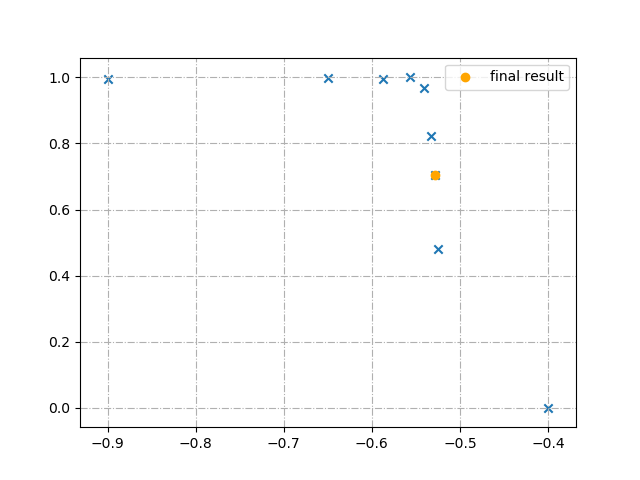

Counts: 195377, Target: 182045
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f186625cfd0>


<IPython.core.display.Javascript object>


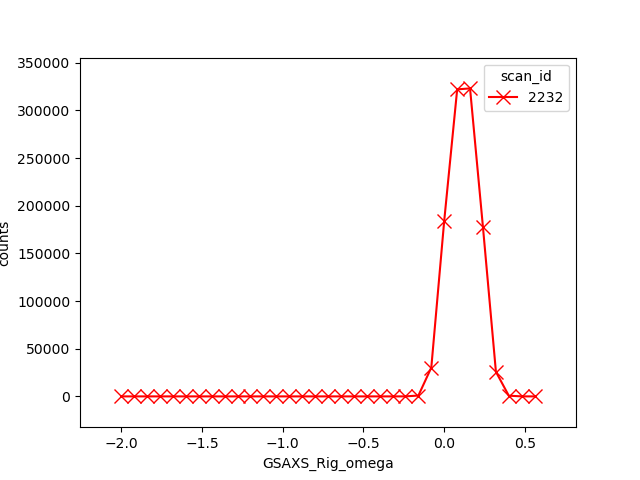

OmegaAnalysis: points at max = [26 27]
omega_scan2: omega_analysis.com = 0.16008074347199386
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at 0.16008074347199386 degrees
Coarse scan peaked at 88.72 % of full flux.
moving sample up after coarse scan because 85 to 95 %
Running Fine Omega Scan
auto_fine_scan_range=  (-0.13, 0.4, 41, 0.013250000000000001)


<IPython.core.display.Javascript object>


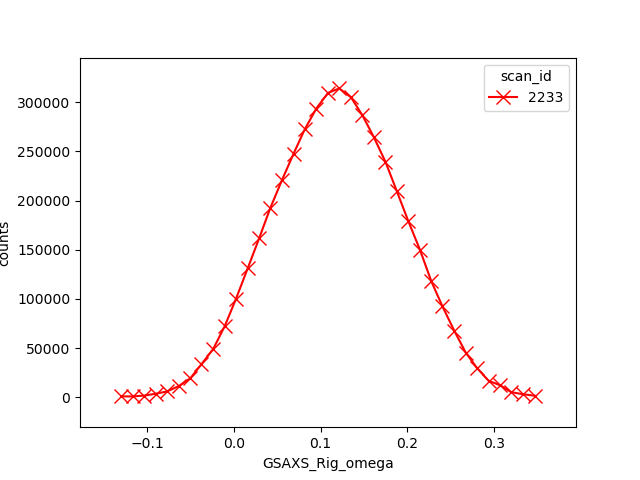

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = 0.12144576467212531
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 11.392 +/- 0.072
sample height displacement, mm = -0.008869 +/- 6.1e-05
sample height displacement, microns = -8.8695 +/- 0.061
sample z displacement, mm = -0.039 +/- -0.039
sample pitch offset, degree = 0.11879 +/- 0.000614
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


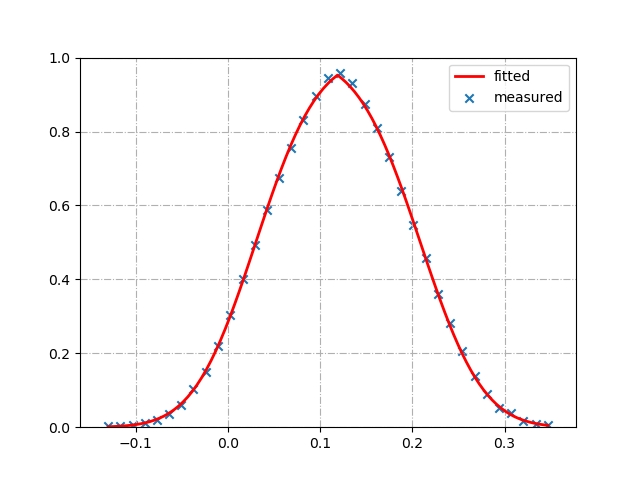

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at -0.5217
Moved sample height to fitted position of  -0.5127 

moving to centre of omega scan at 0.1188 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at -0.5127
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from -0.5502 to,  -0.4752
beam_counts = 364090
fractional_intensity_target = 0.5
i =  0 height =  -0.5127 counts =  175224
i =  1 height =  -0.5503 counts =  360232
i =  2 height =  -0.5312 counts =  353858
i =  3 height =  -0.5217 counts =  320867
i =  4 height =  -0.5172 counts =  269255
i =  5 height =  -0.5148 counts =  221173
i =  6 height =  -0.5137 counts =  201254
i =  7 height =  -0.5133 counts =  189544
final aligned position = -0.5133 final aligned

<IPython.core.display.Javascript object>


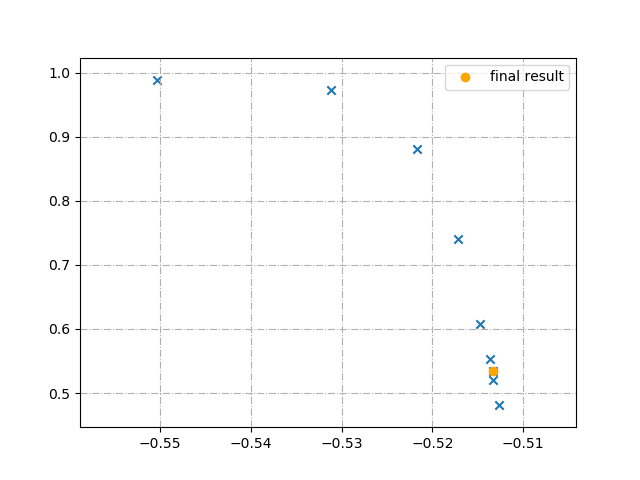

Counts: 192719, Target: 182045
Rezero Omega
nk_final_counts 192719 nk_final_target 182045
Finished alignment successfully. Woot!
Setup for acquisition after align = False


(192719,
 182045,
 -0.5132500000000002,
 0.11879425993584192,
 [-1.9995158856031094,
  -1.9199299442751123,
  -1.8396948072336614,
  -1.7598837182711364,
  -1.6799577150344904,
  -1.5996777629974894,
  -1.5199192565280062,
  -1.4398886205476433,
  -1.3596701239436155,
  -1.2799464216191203,
  -1.200037224865318,
  -1.119716974367809,
  -1.0398986025625474,
  -0.9599230196076494,
  -0.8797336280681034,
  -0.7999751067133767,
  -0.7199353709029251,
  -0.639696070434898,
  -0.5599634475884252,
  -0.47991925652800616,
  -0.3997395270432974,
  -0.3199245696076494,
  -0.23986934231228413,
  -0.15968598330971678,
  -0.07987886472142752,
  2.4893286623361988e-05,
  0.08038810080307235,
  0.16008074347199386,
  0.2401951344033999,
  0.3203261276049504,
  0.4001211352934737,
  0.48004796347293355,
  0.5602932838953747],
 [6.0,
  9.0,
  6.0,
  8.0,
  5.0,
  5.0,
  3.0,
  2.0,
  3.0,
  4.0,
  5.0,
  4.0,
  4.0,
  2.0,
  2.0,
  8.0,
  3.0,
  5.0,
  3.0,
  5.0,
  5.0,
  5.0,
  29.0,
  908.0,
  30217

In [276]:
#############################################################################################################
### PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.52, 200.05, 215, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 416696
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from -2.4422 to,  0.5578
beam_counts = 416696
fractional_intensity_target = 0.5
i =  0 height =  -0.9422 counts =  415486
i =  1 height =  -0.1922 counts =  8
i =  2 height =  -0.5672 counts =  416156
i =  3 height =  -0.3797 counts =  8
i =  4 height =  -0.4733 counts =  414377
i =  5 height =  -0.4262 counts =  983
i =  6 height =  -0.4497 counts =  236875
i =  7 height =  -0.4378 counts =  23227
i =  8 height =  -0.4437 counts =  99220
i =  9 height =  -0.4467 counts =  160532
i =  10 height =  -0.4482 counts =  204235
final aligned position = -0.4487 final aligned counts = 213714 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


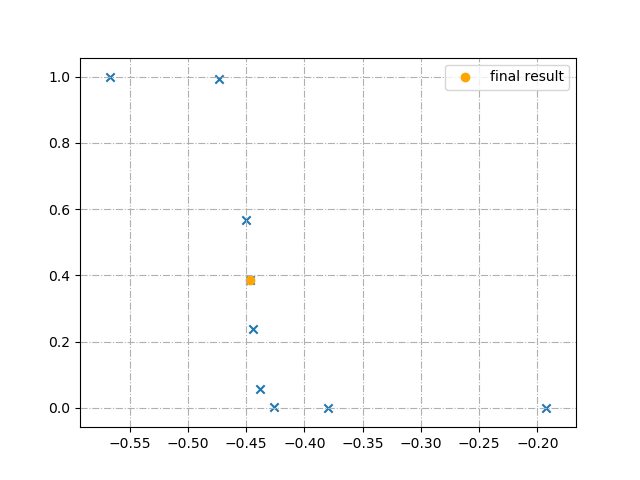

/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Counts: 212875, Target: 208348
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f242c482ac8>


<IPython.core.display.Javascript object>


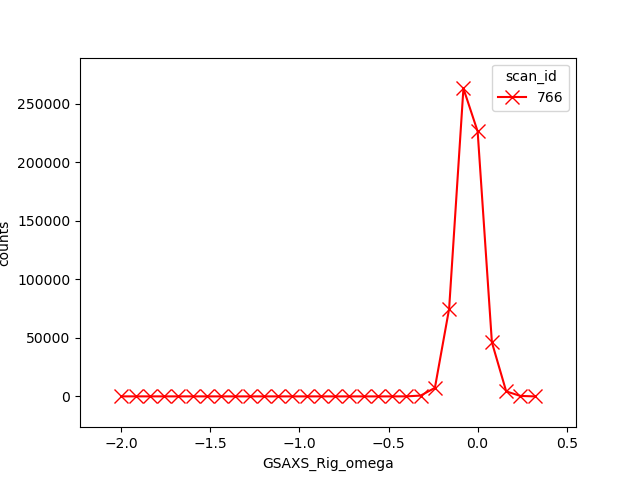

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = -0.07993867030852753
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at -0.07993867030852753 degrees
Coarse scan peaked at 63.12 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (-0.21, 0.15, 41, 0.009)


<IPython.core.display.Javascript object>


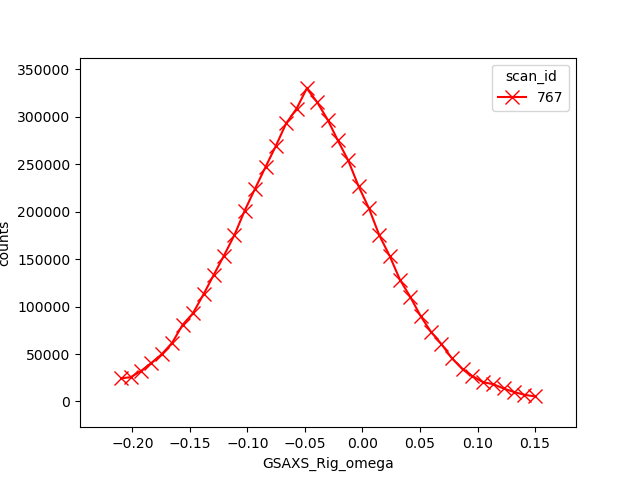

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = -0.04839892643679766
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 10.767 +/- 0.108
sample height displacement, mm = -0.005675 +/- 7e-05
sample height displacement, microns = -5.6746 +/- 0.0701
sample z displacement, mm = 0.132 +/- 0.132
sample pitch offset, degree = -0.046865 +/- 0.000747
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


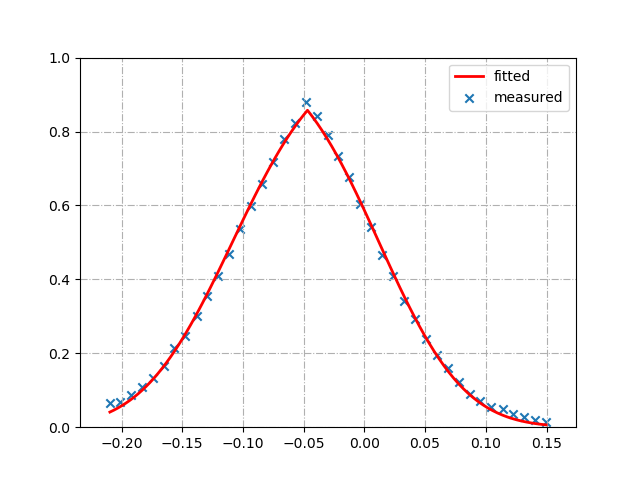

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at -0.4487
Moved sample height to fitted position of  -0.4432 

moving to centre of omega scan at -0.0469 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at -0.4432
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from -0.4807 to,  -0.4057
beam_counts = 416696
fractional_intensity_target = 0.5
i =  0 height =  -0.4432 counts =  199583
i =  1 height =  -0.4807 counts =  415568
i =  2 height =  -0.4618 counts =  410326
i =  3 height =  -0.4523 counts =  360527
i =  4 height =  -0.4478 counts =  292050
i =  5 height =  -0.4452 counts =  235273
i =  6 height =  -0.4443 counts =  214139
i =  7 height =  -0.4437 counts =  199695
final aligned position = -0.4437 final aligne

<IPython.core.display.Javascript object>


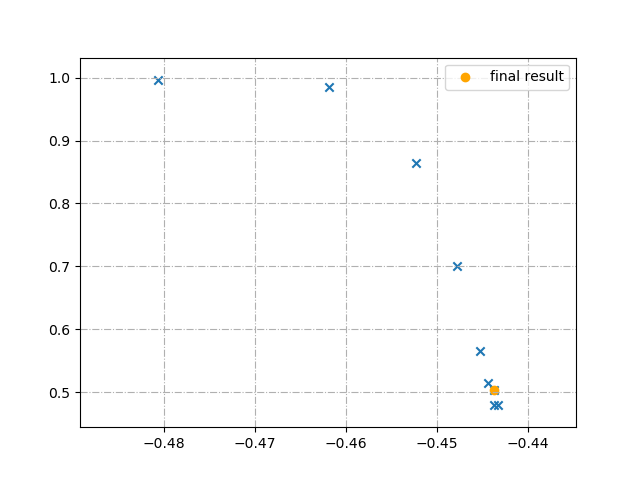

Counts: 210341, Target: 208348
Rezero Omega
nk_final_counts 210341 nk_final_target 208348
Finished alignment successfully. Woot!
Setup for acquisition after align = False
Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.59, 199.96, 215, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 415773
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from -2.4437 to,  0.5563
beam_counts = 415773
fractional_intensity_target = 0.5
i =  0 height =  -0.9437 counts =  416386
i =  1 height =  -0.1937 counts =  5
i =  2 height =  -0.5687 counts =  416189
i =  3 height =  -0.3812 counts =  4
i =  4 height =  -0.4748 counts =  415654
i =  5 height =  -0.4277 counts =  1903
i =  6 height =  -0.4512 counts =  259814
i =  7 height =  -0.4392 counts =  36539
i =  8 height =  -0.4452 counts =  126091
i =  9 height =  -0.4482 counts =  203198
i =  10 height =  -0.4497 c

<IPython.core.display.Javascript object>


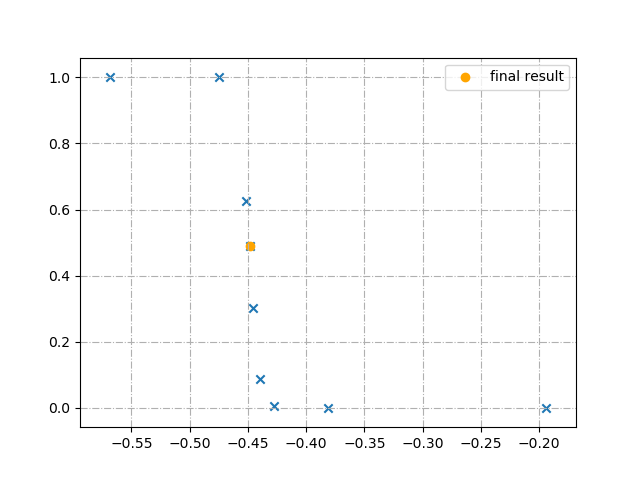

Counts: 214008, Target: 207886
Skipping coarse omega.
skip_fine_omega = True. Now break statement
Final Halvies Height Scan
Counts: 224682, Target: 207886
nk_final_counts 224682 nk_final_target 207886
Skipping new
Finished alignment successfully. Woot!
Setup for acquisition after align = False
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.58, 199.89, 215, 0.08, 10.0]
Finished Setting up for Alignment
Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.56, 199.91, 214, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 422857
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from -2.4487 to,  0.5513
beam_counts = 422857
fractional_intensity_target = 0.5
i =  0 height =  -0.9487 counts =  424975
i =  1 height =  -0.1987 counts =  4
i =  2 height =  -0.5737 counts =  423745
i =  3 height =  -0.3862 counts =  8
i =  4 he

<IPython.core.display.Javascript object>


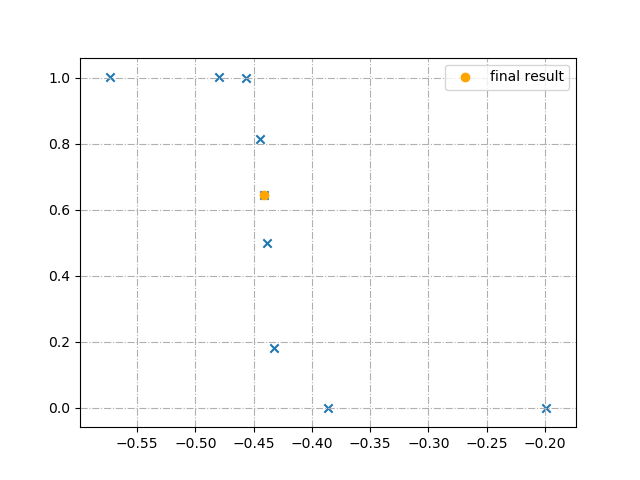

Counts: 239854, Target: 211428
Skipping coarse omega.
skip_fine_omega = True. Now break statement
Final Halvies Height Scan
Counts: 244747, Target: 211428
nk_final_counts 244747 nk_final_target 211428
Skipping new
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [200.07, 200.5, 238, 0.05, 0.2]
Finished Setting up for Acquisition
YAY DONE! Sample alignment positions are:
x: [3.900269403317573, -9.599731800859786, 19.400269403317584]
y: [-0.44374999999999964, -0.44874999999999954, -0.4392499999999995]


<IPython.core.display.Javascript object>


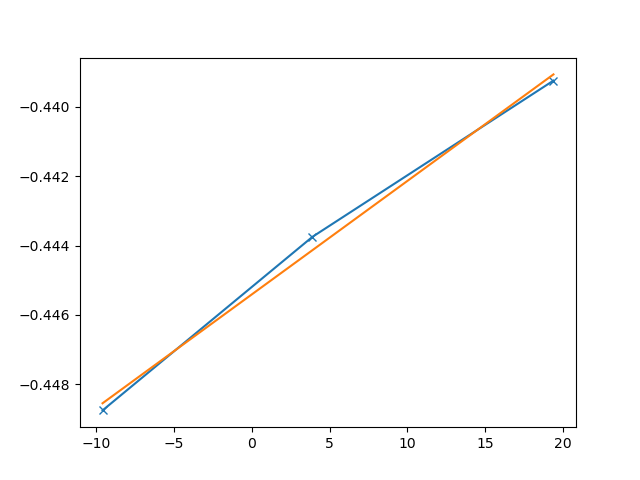

In [264]:
#############################################################################################################
### NOTE: YOU NEED TO START THIS ROUTINE FROM THE SAMPLE RIGHT CORNER.
### PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
offset_from_right_edge = 3 #mm
# MAKE SURE THESE VALUES ARE THE SAME YOU USE BELOW!
sample_width = 37 # mm 
meniscus_width = 5 # mm

sample_alignment_x = []
sample_alignment_y = []

gsaxs.x.velocity.set(2) # move to the stage middle.
initial_x_pos = gsaxs.x.position

gsaxs.x.set(initial_x_pos - sample_width/2, wait=True) # move to the stage middle.
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)
# collect the y value.
sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

# Move to the left edge
gsaxs.x.set(initial_x_pos - sample_width + meniscus_width, wait=True)
# This one for z-alignment only.
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', 
                                    skip_scan = True, 
                                    control_sample_z_displacement=False,  
                                    skip_coarse_omega = True, 
                                    skip_fine_omega = True,                                    
                                     reset_omega = False,
                                     setup_for_acquisition_after_align = False)

sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

# Move to the right edge

gsaxs.x.set(initial_x_pos - offset_from_right_edge, wait=True)
# This one for z-alignment only.
gi.setup_for_alignment()
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', 
                                    skip_scan = True, 
                                    control_sample_z_displacement=False,  
                                    skip_coarse_omega = True, 
                                    skip_fine_omega = True,                                    
                                     reset_omega = False,
                                     setup_for_acquisition_after_align = True)

sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

gsaxs.x.set(initial_x_pos, wait=True)

print("YAY DONE! Sample alignment positions are:")
print(f"x: {sample_alignment_x}")
print(f"y: {sample_alignment_y}")

idxs = np.argsort(sample_alignment_x)
sample_alignment_x = np.array(sample_alignment_x)[idxs]
sample_alignment_y = np.array(sample_alignment_y)[idxs]

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
y_offset_fn = lambda x,a,b: a*x + b
grad_guess = np.mean(np.diff(sample_alignment_y)/np.diff(sample_alignment_x))
offset_guess = 0
popt, pcov = curve_fit(y_offset_fn, sample_alignment_x, sample_alignment_y, p0=[grad_guess, offset_guess])
# Create function
y_offset_line = lambda x: y_offset_fn(np.asarray(x), popt[0], popt[1])
# Plot it
fig, ax = plt.subplots(1,1)
ax.plot(sample_alignment_x, sample_alignment_y, marker="x", label="Data")
ax.plot(sample_alignment_x, y_offset_line(sample_alignment_x), label="Fit")

# Calculation for the angle correction
# print("Correcting angle of roll")
# import math
# roll_correction = np.rad2deg(math.atan(popt[0]))
# curr_roll = gsaxs.chi.position
# print(f"Exsting roll is {curr_roll}")
# print(f"Roll correction is {roll_correction}")
# gsaxs.chi.move(curr_roll + roll_correction)
# print(f"New roll is {gsaxs.chi.position}")

In [260]:
gsaxs.x.set(initial_x_pos, wait=True) # move to the stage middle.
gi.setup_for_alignment()
# gi.setup_for_acquisition()


Setting up for Alignment


LimitError: Value 14 outside of range: [-82.08857970400277, 0.0]

In [125]:
gsaxs.x.velocity.set(2) # move to the stage middle.
gsaxs.x.set(initial_x_pos-37, wait=True) # move to the stage middle.


MoveStatus(done=True, pos=GSAXS_Rig_x, elapsed=4.1, success=True, settle_time=0.0)

In [167]:
# TEST THE BLADE COATING PARAMETERS
sample_width = 34 # mm
meniscus_width = 5 # mm
measurement_time = 1.0 # 1 second. - the time between images.
desired_coating_speed = 0.025 # mm/s | This parameter isn't used.

#base_speed = 0.105001 # 11.1 s acquisition start time, 155s time measuring
base_speed = 0.021 # 52 s acquisition start time, 114 s time measuring
#base_speed = 0.12
#base_speed = 0.04 # 80 s acquisition start time, 80 s time measuring
#base_speed = 1.0 # 134 s acquisition start time, 31 s time measuring


#bug_fix by Robin
detector_start_delay = -4 # seconds - Tell the detector to start acquiring early Should be negative!

blade_velocity = base_speed - desired_coating_speed/2 # mm/s Can parameritise in terms of desired_coating_speed | This parameter is used.
sample_velocity = base_speed + desired_coating_speed/2 # mm/s Can parameritise in terms of desired_coating_speed | This parameter is used.
print(f"Blade velocity:\t\t {blade_velocity} mm/s")
print(f"Sample velocity:\t {sample_velocity} mm/s")

assert blade_velocity > 0, "The speed of the blade towards the beam"
assert sample_velocity > 0, "The speed of the sample towards the beam"
assert sample_velocity > blade_velocity, "The blade must move slower than the beam to coat."
print(f"The coating speed is: \t{sample_velocity - blade_velocity}")
assert np.isclose(desired_coating_speed, sample_velocity - blade_velocity), "The expected coating speed doesn't match the difference of the sample/blade motors."
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(sample_velocity) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert move_blade_and_sample is not None, "Need this function defined...."
assert detector_start_delay < 0, "Negative time only - to pre-empt early acquisition."

# Inferred parameters
time_total = (sample_width-meniscus_width) / (sample_velocity - blade_velocity) # t2
time_acquisition_start = (sample_width - meniscus_width) / sample_velocity / (sample_velocity/blade_velocity  - 1) #t1
time_measuring = time_total - time_acquisition_start
x1 = (sample_width - meniscus_width) / (sample_velocity/blade_velocity - 1) # The required distance from the blade edge to the beam 
blade_movement = x1
sample_movement = x1 + (sample_width - meniscus_width)

print(f"Acquisition start time:\t{time_acquisition_start} s")
print(f"Time measuring:\t\t{time_measuring} s")
print(f"Total time coating:\t{time_total} s")
print(f"Blade movement:\t\t{blade_movement} mm")
print(f"Sample movement:\t{sample_movement} mm")

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // (measurement_time + 0.005) + 1)
print(f"Number of shots {num_shots}")

# Get the y-offset value for the current position
# y_initial = y_offset_line(gsaxs.x.position) # The position at which the sample should be aligned with the beam.
# y_final = y_offset_line(gsaxs.x.position - sample_movement)
# stage_y_velocity = abs(y_final - y_initial)/time_total
# print(f"Stage Y Movement:\t{abs(y_final-y_initial)} mm\nStage Y Speed:\t\t{stage_y_velocity} mm/s")

#added assert positions of sample and blade, because moving out of limits can also easily cause problems
assert (gsaxs.x.limits[0] < gsaxs.x.position + x1) and (gsaxs.x.position + x1 < gsaxs.x.limits[1]), f"Sample movement position {gsaxs.x.position + x1} is not within limits {gsaxs.x.limits}"
assert (gi.blade_x.limits[0] < gi.blade_x.position + x1) and (gi.blade_x.position + x1 < gi.blade_x.limits[1]), f"Blade movement position {gi.blade_x.position + x1} is not within limits {gi.blade_x.limits}"

print("Checked!")


Blade velocity:		 0.0085 mm/s
Sample velocity:	 0.0335 mm/s
The coating speed is: 	0.025
Acquisition start time:	294.32835820895525 s
Time measuring:		865.6716417910447 s
Total time coating:	1160.0 s
Blade movement:		9.860000000000001 mm
Sample movement:	38.86 mm
Number of shots 862
Checked!


In [119]:
origin_sample_x, x1, sample_movement, (origin_sample_x + x1 -sample_movement)


(19.000284280673753,
 5.333333333333334,
 37.333333333333336,
 -12.999715719326247)

In [113]:
# num_shots = 20
# fast_GI_scan_multi_shot(filename = "fast_test", exposure_time = 0.1, number_shots=num_shots)

# # if time_acquisition_start > abs(detector_start_delay):
# #     time.sleep(abs(detector_start_delay))
    
# # Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
# f_num = file_number.get()
# f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 
# initial_f2_num = f2_num #bugfix by fabian
# changing_frame = False
# initial_time = time.time()
# for i in range(num_shots):
#     # Get the current frame number.
#     f2_num = frame_number.get() # Get the current number.
#     t = time.time()
    
#     # Are we changing frames yet?
#     while not changing_frame:
#         f2_num = frame_number.get() # Get the current number.
#         if f2_num != initial_f2_num:
#             changing_frame = True
#         time.sleep(0.05)
    
#     # Skip to current frame
#     if i <= f2_num:
#         print(f"Missed frame {i}, skipping record")
#         continue
        
#     while f2_num != i:
#         time.sleep(0.05)
#         f2_num = frame_number.get() # Get the current number.
        
#     # Print the number if we hit a multiple of 50!
# #     if (i%50)==0:

#     t = time.time() - initial_time
#     print(f"At scan i={i}, t={t}")
    
#     # Now measuring shot #i

Missed frame 0, skipping record
At scan i=1, t=3.717294454574585
At scan i=2, t=4.722672700881958
At scan i=3, t=5.726987600326538
At scan i=4, t=6.731414794921875
At scan i=5, t=7.73586368560791
At scan i=6, t=8.740680694580078
At scan i=7, t=9.745554447174072
At scan i=8, t=10.750601291656494
At scan i=9, t=11.755137205123901
At scan i=10, t=12.7597074508667
At scan i=11, t=13.765028238296509
At scan i=12, t=14.769930362701416
At scan i=13, t=15.775304555892944
At scan i=14, t=16.779629945755005
At scan i=15, t=17.78408908843994
At scan i=16, t=18.788654565811157
At scan i=17, t=19.793436527252197
At scan i=18, t=20.79805326461792
At scan i=19, t=21.803680896759033


In [309]:
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [310]:
# # Robin's (&Suhba's) SLOW Blade Coating, Huzzah! 
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is <edge_offset> mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the desired angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
sample_name = "S08_01_r01"
# sample_name = "testing_slow2"
angle_of_incidence = 0.1
sample_width = 34 # mm
meniscus_width = 5 # mm
measurement_time = 1.5 # 1 second. - the time between images.
detector_start_delay = -4 # seconds - Tell the detector to start acquiring early Should be negative!
desired_coating_speed = 0.025 #mm/s | This parameter isn't used.
# MAKE SURE YOU'VE SET THE TEMPERATURE SETPOINTS ABOVE ^

#base_speed = 0.12 # 11.1 s acquisition start time, 155s time measuring
base_speed = 0.021 # 52 s acquisition start time, 114 s time measuring
# base_speed = 0.3 # 80 s acquisition start time, 80 s time measuring
#base_speed = 1.0 # 134 s acquisition start time, 31 s time measuring
#base_speed = 0.04

blade_velocity = base_speed - desired_coating_speed/2 # mm/s Can parameritise in terms of desired_coating_speed | This parameter is used.
sample_velocity = base_speed + desired_coating_speed/2 # mm/s Can parameritise in terms of desired_coating_speed | This parameter is used.

print(f"Blade velocity: {blade_velocity} mm/s")
print(f"Sample velocity: {sample_velocity} mm/s")
assert blade_velocity > 0, "The speed of the blade towards the beam"
assert sample_velocity > 0, "The speed of the sample towards the beam"
assert sample_velocity > blade_velocity, "The blade must move slower than the beam to coat."
print(f"The coating speed is: \t{sample_velocity - blade_velocity}")
assert np.isclose(desired_coating_speed, sample_velocity - blade_velocity), "The expected coating speed doesn't match the difference of the sample/blade motors."
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(sample_velocity) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert safety_measurement, "Make sure you save yo' data."
assert move_blade_and_sample is not None, "Need this function defined...."
assert detector_start_delay < 0, "Negative time only - to pre-empt early acquisition."
assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "

# Store the original positions.
origin_blade_x = gi.blade_x.position
origin_sample_x = gsaxs.x.position

# Inferred parameters
time_total = (sample_width-meniscus_width) / (sample_velocity - blade_velocity) # t2
time_acquisition_start = (sample_width - meniscus_width) / sample_velocity / (sample_velocity/blade_velocity  - 1) #t1
time_measuring = time_total - time_acquisition_start
x1 = (sample_width - meniscus_width) / (sample_velocity/blade_velocity - 1) # The required distance from the blade edge to the beam 
blade_movement = x1
sample_movement = x1 + (sample_width - meniscus_width)

print(f"Acquisition start time:\t{time_acquisition_start} s")
print(f"Time measuring:\t\t{time_measuring} s")
print(f"Total time coating:\t{time_total} s")
print(f"Blade movement:\t\t{blade_movement} mm")
print(f"Sample movement:\t{sample_movement} mm")

# Calculate number of shots and start shooting
# The actual number of shots is determined by the "acquire period", not the measurement_time.
# acquire_period = PV("SR13ID01PIL1:cam1:AcquirePeriod")

num_shots = int((time_measuring) // (measurement_time + 0.005) + 1) # 5 ms offset default for detector acquisition.
print(f"Number of shots {num_shots} using detector period of {measurement_time + 0.005 : 0.3f}")

# More assertions
assert num_shots < 1000, f"Do you really want to shoot {num_shots} > 1000? oof."
assert (gsaxs.x.limits[0] < gsaxs.x.position + x1) and (gsaxs.x.position + x1 < gsaxs.x.limits[1]), f"Sample movement position {gsaxs.x.position + x1} is not within limits {gsaxs.x.limits}"
assert (gi.blade_x.limits[0] < gi.blade_x.position + x1) and (gi.blade_x.position + x1 < gi.blade_x.limits[1]), f"Blade movement position {gi.blade_x.position + x1} is not within limits {gi.blade_x.limits}"
assert len(sample_alignment_x) == 3
assert len(sample_alignment_y) == 3

# Setup the initial position relative to the beam centre - x1.
gi.pitch_motor.move(angle_of_incidence, wait = True)
move_blade_and_sample(x1, 1, wait=True) # move everything forward x1.


# Get the y-offset value for the current position
# y_initial = y_offset_line(gsaxs.x.position) # The position at which the sample should be aligned with the beam.
# assert abs(y_initial - gi.fine_y_motor.position) < 0.5 # The y movement distance should be less than 500um, otherwise estimation is probably wrong.
# gi.fine_y_motor.velocity.set(0.1)
# gi.fine_y_motor.set(y_initial, wait=True)

# Set the velocity for the sample y
# gi.fine_y_motor.velocity.set(stage_y_velocity)
gi.fine_y_motor.velocity.set(0.02)

print("Moved to initial position.")

# Set the velocities for the coating.
gi.blade_x.velocity.set(blade_velocity)
gsaxs.x.velocity.set(sample_velocity)

# Capture names
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Save the information
if safety_measurement:
   data = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "blade_x (mm)" : [],
       "sample_x (mm)" : [],
       "sample_y (mm)" : [],
       "temp_linkam (deg)" : [],
       "temp_centre (deg)" : [],
       "temp_edge (deg)" : [],
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")

start_time = time.time() # KEEP THE OLD START TIME FOR ACCURATE DRY TIME.
print("{0:0.3f} Setting motors to start blade coating.")

# Set the blade coating going.
gi.blade_x.set(gi.blade_x.position - blade_movement, wait=False)
gsaxs.x.set(gsaxs.x.position - sample_movement, wait=False)

# Delay if the acquisition wait time is longer than movement.
if time_acquisition_start > abs(detector_start_delay):
    print(f"Waiting {time_acquisition_start} s till beginning image capture.")
    time.sleep(time_acquisition_start + detector_start_delay)
    print("Beginning detector acquisition due to delay")
else:
    print("Beginning detector acquisition immediately")    

# Set the detector going
print("Starting fast image acquisition...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

if time_acquisition_start > abs(detector_start_delay):
    time.sleep(abs(detector_start_delay))
    
# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 
initial_f2_num = f2_num #bugfix by fabian
changing_frame = False
for i in range(num_shots):
    # Get the current frame number.
    f2_num = frame_number.get() # Get the current number.
    t = time.time()
    
    # Are we changing frames yet?
    while not changing_frame:
        f2_num = frame_number.get() # Get the current number.
        if f2_num != initial_f2_num:
            changing_frame = True
        time.sleep(0.05)
    
    # Skip to current frame
    if i <= f2_num:
        print(f"Missed frame {i}, skipping record")
        continue
        
    while f2_num != i:
        time.sleep(0.05)
        f2_num = frame_number.get() # Get the current number.
        
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
    curr_linkam_temp = linkam_temp.get()
    curr_edge_temp = usbtemp1.t1.get()
    curr_centre_temp = usbtemp1.t2.get()
    curr_y_val = gsaxs.y.position
    
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    data["sample_y (mm)"].append(curr_sample_y)
    data["temp_linkam (deg)"].append(curr_linkam_temp)
    data["temp_centre (deg)"].append(curr_centre_temp)
    data["temp_edge (deg)"].append(curr_edge_temp)

    # Set a new y-position if the y-value is not where it's meant to be for the given x-position.
    desired_sample_y = y_offset_line(curr_sample_x)
    setpoint_sample_y = gi.fine_y_motor.get().user_setpoint
    if abs(setpoint_sample_y - desired_sample_y) > 0.005: # 5 um tolerance before updating the value
        # Update the setpoint
        gi.fine_y_motor.set(desired_sample_y, wait=False)
    
print("Fast measurement complete!")

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "sample_name" : sample_name,
            "number of images" : num_shots,
            "total time (s)" : time_total,
            "time_acquisition_start (s)": time_acquisition_start,
            "time_measuring (s)" : time_measuring ,
            "blade_movement (mm)" : blade_movement ,
            "sample_movement (mm)" : sample_movement,
            "sample_width (mm)" : sample_width,
            "meniscus_width (mm)" : meniscus_width,
            "desired_coating_speed (mm/s)" : desired_coating_speed,
            "base_speed (mm/s)" : base_speed,
            "blade_velocity (mm/s)" : blade_velocity,
            "sample_velocity (mm/s)" : sample_velocity,
            "measurement_time (s)" : measurement_time,
            "detector_start_delay (s)" : detector_start_delay,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
safety_measurement = False
        
# ###########################################################################################################

time.sleep(3)

# move the blade up
gi.blade_y.velocity.set(1.0)
gi.blade_y.set(gi.blade_y.position + 3, wait=True)
gi.blade_y.velocity.set(2.0)
gi.blade_y.set(gi.blade_y.position + 7, wait=True)

time.sleep(2)

move_blade_and_sample((sample_width - meniscus_width) * 0.6, 1.0, wait=True)

# Do not align... 
## gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)

curr_sample_x = gsaxs.x.position
desired_sample_y = y_offset_line(curr_sample_x)
gi.fine_y_motor.velocity.set(0.1)
gi.fine_y_motor.set(desired_sample_y, wait=True)

print("Performing angle of incidence scan!")
# Setup angles
angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=sample_name, setup=False, exposure_time=1.0)

# Data is collected
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)
gi.fine_y_motor.velocity.set(1.0)
gi.pitch_motor.move(angle_of_incidence, wait = True)

# # Move the sample back the remaining amount.
gi.blade_x.set(origin_blade_x)
gsaxs.x.set(origin_sample_x)


print("Finished!")

Blade velocity: 0.0085 mm/s
Sample velocity: 0.0335 mm/s
The coating speed is: 	0.025
Acquisition start time:	294.32835820895525 s
Time measuring:		865.6716417910447 s
Total time coating:	1160.0 s
Blade movement:		9.860000000000001 mm
Sample movement:	38.86 mm
Number of shots 576 using detector period of  1.505
Moved to initial position.
{0:0.3f} Setting motors to start blade coating.
Waiting 294.32835820895525 s till beginning image capture.
Beginning detector acquisition due to delay
Starting fast image acquisition...
Missed frame 0, skipping record
Missed frame 1, skipping record
At scan i=50
At scan i=100
At scan i=150
At scan i=200
At scan i=250
At scan i=300
At scan i=350
At scan i=400
At scan i=450
At scan i=500
At scan i=550
Fast measurement complete!
Performing angle of incidence scan!
Finished!


1754039330.2346406

In [82]:
# move_blade_and_sample(0.05, 1, wait=True)#bufix of direction of motion
# move_blade_and_sample(-0.5, 1.0, wait=True)
# gi.setup_for_acquisition()
# gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)

print("Performing angle of incidence scan!")
# Setup angles
angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=sample_name, setup=False, exposure_time=1.0)

# Move the sample back the remaining amount.

print("Finished")


MoveStatus(done=True, pos=GSAXS_Rig_omega, elapsed=1.2, success=True, settle_time=0.0)

In [ ]:

################################################
######## Are you ready!? to override the dry data?
################################################
safety_measurement_dry = True

In [287]:
## NEW DRY SCAN

sample_name_dry = sample_name + "_dry"
if safety_measurement_dry:
   data_dry = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "blade_x (mm)" : [],
       "sample_x (mm)" : [],
       "sample_y (mm)" : [],
       "temp_linkam (deg)" : [],
       "temp_centre (deg)" : [],
       "temp_edge (deg)" : [],
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")

gi.pitch_motor.move(angle_of_incidence, wait = True)
gsaxs.x.set(start_position_sample, wait=True)
gsaxs.x.velocity.set(sample_velocity)
gi.fine_y_motor.velocity.set(0.02)

gsaxs.x.set(start_position_sample - (sample_width - meniscus_width), wait=False)

# Set the detector going
print("Starting fast image acquisition...")
fast_GI_scan_multi_shot(filename = sample_name_dry, exposure_time = measurement_time, number_shots=num_shots)

start_time=time.time() #bugfix by fabian
    
# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 
initial_f2_num = f2_num #bugfix by fabian
changing_frame = False
for i in range(num_shots):
    # Get the current frame number.
    f2_num = frame_number.get() # Get the current number.
    t = time.time()
    
    # Are we changing frames yet?
    while not changing_frame:
        f2_num = frame_number.get() # Get the current number.
        if f2_num != initial_f2_num:
            changing_frame = True
        time.sleep(0.05)
    
    # Skip to current frame
    if i <= f2_num:
        print(f"Missed frame {i}, skipping record")
        continue
        
    while f2_num != i:
        time.sleep(0.05)
        f2_num = frame_number.get() # Get the current number.
        
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
    curr_linkam_temp = linkam_temp.get()
    curr_edge_temp = usbtemp1.t1.get()
    curr_centre_temp = usbtemp1.t2.get()
    curr_y_val = gsaxs.y.position
    
    fname = sample_name_format_frame.format(sample_name=sample_name_dry, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data_dry["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data_dry["scan#"].append(f_num)
    data_dry["filename"].append(fname)
    data_dry["blade_x (mm)"].append(curr_blade_x)
    data_dry["sample_x (mm)"].append(curr_sample_x)
    data_dry["sample_y (mm)"].append(curr_sample_y)
    data_dry["temp_linkam (deg)"].append(curr_linkam_temp)
    data_dry["temp_centre (deg)"].append(curr_centre_temp)
    data_dry["temp_edge (deg)"].append(curr_edge_temp)

    # Set a new y-position if the y-value is not where it's meant to be for the given x-position.
    desired_sample_y = y_offset_line(curr_sample_x)
    setpoint_sample_y = gi.fine_y_motor.get().user_setpoint
    if abs(setpoint_sample_y - desired_sample_y) > 0.005: # 5 um tolerance before updating the value
        # Update the setpoint
        gi.fine_y_motor.set(desired_sample_y, wait=False)
    
print("Fast measurement complete!")

 
print("Fast measurement complete!")

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data_dry.values()]).T
header = list(data_dry.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name_dry)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "sample_name" : sample_name_dry,
            "number of images" : num_shots,
            "total time (s)" : time_total,
            "time_acquisition_start (s)": time_acquisition_start,
            "time_measuring (s)" : time_measuring ,
            "blade_movement (mm)" : blade_movement ,
            "sample_movement (mm)" : sample_movement,
            "sample_width (mm)" : sample_width,
            "meniscus_width (mm)" : meniscus_width,
            "desired_coating_speed (mm/s)" : desired_coating_speed,
            "base_speed (mm/s)" : base_speed,
            "blade_velocity (mm/s)" : blade_velocity,
            "sample_velocity (mm/s)" : sample_velocity,
            "measurement_time (s)" : measurement_time
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
safety_measurement_dry = False
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)
gi.fine_y_motor.velocity.set(1.0)
gi.pitch_motor.move(angle_of_incidence, wait = True)

Starting fast image acquisition...
Missed frame 0, skipping record
At scan i=50
At scan i=100
Fast measurement complete!
Fast measurement complete!


In [484]:
#############################################################################################################################################
#############################################################################################################################################
############################################### XU's FAST BLADE COATING V2 - Now with height correction!
#############################################################################################################################################
#############################################################################################################################################

#############################################################################################################
### NOTE: YOU NEED TO START THIS ROUTINE FROM THE SAMPLE RIGHT CORNER.
### PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
offset_from_right_edge = 3 #mm
# MAKE SURE THESE VALUES ARE THE SAME YOU USE BELOW!
sample_width = 45 # mm 
meniscus_width = 5 # mm

sample_alignment_x = []
sample_alignment_y = []

gsaxs.x.velocity.set(2) # move to the stage middle.
initial_x_pos = gsaxs.x.position

gsaxs.x.set(initial_x_pos - sample_width/2, wait=True) # move to the stage middle.
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)
# collect the y value.
sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

# Move to the left edge
gsaxs.x.set(initial_x_pos - sample_width + meniscus_width, wait=True)
# This one for z-alignment only.
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', 
                                    skip_scan = True, 
                                    control_sample_z_displacement=False,  
                                    skip_coarse_omega = True, 
                                    skip_fine_omega = True,                                    
                                     reset_omega = False,
                                     setup_for_acquisition_after_align = False)

sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

# Move to the right edge

gsaxs.x.set(initial_x_pos - offset_from_right_edge, wait=True)
# This one for z-alignment only.
gi.setup_for_alignment()
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', 
                                    skip_scan = True, 
                                    control_sample_z_displacement=False,  
                                    skip_coarse_omega = True, 
                                    skip_fine_omega = True,                                    
                                     reset_omega = False,
                                     setup_for_acquisition_after_align = True)

sample_alignment_x.append(gsaxs.x.position)
sample_alignment_y.append(gi.fine_y_motor.position)

gsaxs.x.set(initial_x_pos, wait=True)

print("YAY DONE! Sample alignment positions are:")
print(f"x: {sample_alignment_x}")
print(f"y: {sample_alignment_y}")

idxs = np.argsort(sample_alignment_x)
sample_alignment_x = np.array(sample_alignment_x)[idxs]
sample_alignment_y = np.array(sample_alignment_y)[idxs]

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
y_offset_fn = lambda x,a,b: a*x + b
grad_guess = np.mean(np.diff(sample_alignment_y)/np.diff(sample_alignment_x))
offset_guess = 0
popt, pcov = curve_fit(y_offset_fn, sample_alignment_x, sample_alignment_y, p0=[grad_guess, offset_guess])
# Create function
y_offset_line = lambda x: y_offset_fn(np.asarray(x), popt[0], popt[1])
# Plot it
fig, ax = plt.subplots(1,1)
ax.plot(sample_alignment_x, sample_alignment_y, marker="x", label="Data")
ax.plot(sample_alignment_x, y_offset_line(sample_alignment_x), label="Fit")

# Calculation for the angle correction
# print("Correcting angle of roll")
# import math
# roll_correction = np.rad2deg(math.atan(popt[0]))
# curr_roll = gsaxs.chi.position
# print(f"Exsting roll is {curr_roll}")
# print(f"Roll correction is {roll_correction}")
# gsaxs.chi.move(curr_roll + roll_correction)
# print(f"New roll is {gsaxs.chi.position}")



Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [199.64, 200.06, 214, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function


RuntimeError: The RunEngine is in a paused state

In [472]:
#############################################################################################################################################
#############################################################################################################################################
############################################### XU's FAST BLADE COATING V2 - Now with height correction!
#############################################################################################################################################
#############################################################################################################################################

# CHECK YOUR PARAMETERS HERE.
angle_of_incidence = 0.1
sample_width = 45 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
meniscus_width = 5 # mm
measurement_time = 0.15 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -3 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring =  50 # 8 mins
detector_start_delay = -4 # Delay of the detector

# The Blade coating speeds
# ## 1mm/s :
desired_blade_speed = 1 #mm / s 
blade_velocity = 0.8 #mm/s
stage_velocity_with_blade = -0.2 #mm/s (maximum is 2)

## 5mm/s
#desired_blade_speed = 5 #mm / s 
#blade_velocity = 4.8 #mm/s
#stage_velocity_with_blade = -0.2 #mm/s (maximum is 2)

# SET the attenuation factor!
si_attenuation_length = 800
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

post_measurement_image_intervals = [30, 30, 30] # The times to consecutively wait and take extra gapless images after the main fast sequence.
post_measurement_angle_scan_interval = 30 #consecutive time to wait for angle scan

# Limits
assert desired_blade_speed == (blade_velocity - stage_velocity_with_blade), "Velocities don't add up."
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0
assert blade_velocity > 0, "The speed of the blade towards the left"
assert stage_velocity_with_blade < 0, "The speed of the sample towards the right (-ve)."
assert stage_velocity_with_blade < blade_velocity, "The blade must move left, the sample right."
assert safety_measurement, "Make sure you save yo' data."
assert move_blade_and_sample is not None, "Need this function defined...."
assert detector_start_delay < 0, "Negative time only - to pre-empt early acquisition."
assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "
assert attenuation_factor is not None

# Calculate the time taken for the blade to reach the final 5mm of the sample
print(f"The total time will be {time_measuring}")
t_coating = (sample_width - initial_blade_offset_from_right_edge - meniscus_width) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s of the full measurement {time_measuring} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 9 # 9 is 5mm blade final position + 4mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas} mm.")
assert x_meas > 10, "Minimum measurement width is 10mm..."

# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating)) * 0.5 # Add an extra factor to reduce speed as the detector has some delay in image taking.
assert stage_speed_after_coat > (0.05 / attenuation_factor), f"The measurement coating speed is {stage_speed_after_coat}, should be >={0.05/attenuation_factor} mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"
print(f"Stage speed after coating {stage_speed_after_coat} mm/s")

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // (measurement_time + 0.005) + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
attenuation_factor = None # reset this to make sure.

Attenuation factor: 5.9166935906643285
The total time will be 50
The time taken to complete the coating will be 33.0 s of the full measurement 50 s.
The x-measurement length after the coating will be 19.4 mm.
Stage speed after coating 0.5705882352941176 mm/s
Number of shots 323


In [475]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
si_attenuation_length = 0 # Default should be 0 for no attenuation.
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

Attenuation factor: 1.0


"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [476]:
#############################################################################################################################################
#############################################################################################################################################
############################################### XU's FAST BLADE COATING V2 - Now with height correction!
#############################################################################################################################################
#############################################################################################################################################

# # Xu's FAST Blade Coating!
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is <edge_offset> mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the desired angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
# sample_name = "testing_fast_scan"
sample_name = "S1_03_r01"
angle_of_incidence = 0.1
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
meniscus_width = 5 # mm
measurement_time = 0.15 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -4 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring =  50 # 8 mins
detector_start_delay = -4 # Delay of the detector

# The blade coating speeds!
desired_blade_speed = 1 #mm / s 
blade_velocity = 0.8 #mm/s
stage_velocity_with_blade = -0.2 #mm/s (maximum is 2)

# SET the attenuation factor!
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

post_measurement_image_intervals = [10, 10, 10] # The times to consecutively wait and take extra gapless images after the main fast sequence.
post_measurement_angle_scan_interval = 10 #consecutive time to wait for angle scan

############################################################
######################## LIMIT CHECKING!!!!!!
############################################################
assert desired_blade_speed == (blade_velocity - stage_velocity_with_blade), "Velocities don't add up."
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0
assert blade_velocity > 0, "The speed of the blade towards the left"
assert stage_velocity_with_blade < 0, "The speed of the sample towards the right (-ve)."
assert stage_velocity_with_blade < blade_velocity, "The blade must move left, the sample right."
assert safety_measurement, "Make sure you save yo' data."
assert move_blade_and_sample is not None, "Need this function defined...."
assert detector_start_delay < 0, "Negative time only - to pre-empt early acquisition."
assert (measurement_time <= 0.495) or (measurement_time >= 0.6), f"Detector acquisition timing breaks between 0.495 and 0.6 s. STAY AWAY. Is {measurement_time} "
assert attenuation_factor is not None
assert si_attenuation_length is not None

# Calculate the time taken for the blade to reach the final 5mm of the sample
print(f"The total time will be {time_measuring}")
t_coating = (sample_width - initial_blade_offset_from_right_edge - meniscus_width) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s of the full measurement {time_measuring} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 9 # 9 is 5mm blade final position + 4mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas} mm.")
assert x_meas > 10, "Minimum measurement width is 10mm..."
print(f"The total time will be {t_coating} ")

# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating)) * 0.5 # Add an extra factor to reduce speed as the detector has some delay in image taking.
assert stage_speed_after_coat > (0.05 / attenuation_factor), f"The measurement coating speed is {stage_speed_after_coat}, should be >={0.05/attenuation_factor} mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"
print(f"Stage speed after coating {stage_speed_after_coat} mm/s")

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // (measurement_time + 0.005) + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    

# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

############################################################
##### START DOING THE MEASUREMENT.
############################################################

# Record the origin positions
origin_blade_x = gi.blade_x.position
origin_sample_x = gsaxs.x.position

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)

# move to dry spot!!
move_blade_and_sample(dry_offset, 1.0, wait=True) # Move -5 mm for the meniscus, and -2mm for a dry offset!
# Set the y position
gi.fine_y_motor.velocity.set(1.0)
desired_sample_y = y_offset_line(origin_sample_x)
gi.fine_y_motor.set(desired_sample_y, wait=True)
gi.fine_y_motor.velocity.set(0.02) # Make the velocity slow so we don't overshoot mid sample.

# Calculate a velocity for the blade to move
# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position
# Calculate movement of motors for the coating
final_blade_x = init_blade_x + (blade_velocity * t_coating)
final_sample_x = init_sample_x + (stage_velocity_with_blade * t_coating)

print(f"stage velocity {gsaxs.x.velocity}")

# Setup saving for the information
if safety_measurement:
   data = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "blade_x (mm)" : [],
       "sample_x (mm)" : [],
       "sample_y (mm)" : [],
       "temp_linkam (deg)" : [],
       "temp_centre (deg)" : [],
       "temp_edge (deg)" : [],
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")

#print("Measured the dry point.") 
print(" Starting full measurement in...\n3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")


# SETUP NEW VELOCITIIES
gi.blade_x.velocity.put(abs(blade_velocity))
gsaxs.x.velocity.put(abs(stage_velocity_with_blade))
print(f"stage velocity {gsaxs.x.velocity}")
gi.fine_y_motor.velocity.set(0.02)

# Start shooting
print("Starting fast image acquisition and moving sample...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

if detector_start_delay < 0:
    time.sleep(abs(detector_start_delay))
    
# Start the blade coating!
start_time = time.time()

#### Start the movement of the motors after initializing the camera.
gi.blade_x.set(final_blade_x, wait=False)
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 

coating_finished = False
changing_frame = False # Have we changed frame number yet? at all? 
initial_f2_num = f2_num
for i in range(num_shots):
    # Get the current frame number.
    f2_num = frame_number.get() # Get the current number.
    
    # Are we changing frames yet?
    while not changing_frame:
        f2_num = frame_number.get() # Get the current number.
        if f2_num != initial_f2_num:
            changing_frame = True
        time.sleep(0.01)
    
    # Skip to current frame
    if i <= f2_num:
        print(f"Missed frame {i}, skipping record")
        continue    
        
    while f2_num != i:
        time.sleep(0.01)
        f2_num = frame_number.get() # Get the current number.
        
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()

    # Params
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
    curr_linkam_temp = linkam_temp.get()
    curr_edge_temp = usbtemp1.t1.get()
    curr_centre_temp = usbtemp1.t2.get()
    curr_y_val = gsaxs.y.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber

    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    data["sample_y (mm)"].append(curr_sample_y)
    data["temp_linkam (deg)"].append(curr_linkam_temp)
    data["temp_centre (deg)"].append(curr_centre_temp)
    data["temp_edge (deg)"].append(curr_edge_temp)
    
    # Set a new y-position if the y-value is not where it's meant to be for the given x-position.
    desired_sample_y = y_offset_line(curr_sample_x)
    setpoint_sample_y = gi.fine_y_motor.get().user_setpoint
    if abs(setpoint_sample_y - desired_sample_y) > 0.004: # 4 um tolerance before updating the value
        # Update the setpoint
        gi.fine_y_motor.set(desired_sample_y, wait=False)
    
    # Have we finished coating? Do a check, calculate the translation required.
    d1 = abs(final_sample_x - curr_sample_x)
    d2 = abs(final_blade_x - curr_blade_x)
    if (not coating_finished) and (d1 < 0.01) and (d2 < 0.01):
        print(f"end position reached with d1={d1} and d2={d2}, i={i}")
        coating_finished = True
        
        ## move the sample and the blade forwards
        #speeds
        gi.blade_x.velocity.put(stage_speed_after_coat)
        gsaxs.x.velocity.put(stage_speed_after_coat)
        
        #print(f"blade velocity {gi.blade_x.velocity}")
        #print(f"stage velocity {gsaxs.x.velocity}")
        
        #Set the new values to current values plus the delta
        gsaxs.x.set(gsaxs.x.position - x_meas, wait=False) 
        gi.blade_x.set(gi.blade_x.position - x_meas, wait=False)

print("Fast measurement completed.")

# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.

#Move the blade up
gi.blade_y.velocity.set(0.1)
gi.blade_y.set(gi.blade_y.position + 3, wait=True)
gi.blade_y.velocity.set(2)
gi.blade_y.set(gi.blade_y.position + 7, wait=False)

post_time = 0
for post_time_offset in post_measurement_image_intervals:
    # Accumulate
    post_time += post_time_offset
    
    # Measure
    print(f"Waiting to take `dry` shot after {post_time}s")
    time.sleep(post_time_offset)
    print(f"Taking `dry` shot at t=~{time.time() - start_time}s")
    angles = [angle_of_incidence]
    gi.acquire_angles = angles
    gi.X_position_relative_list = [-0.05] * len(angles)
    gi.beamstop_positions = [gi.beamstop_height] * len(angles)
    f_num = file_number.get()

    fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
    gi.scan_that_thang(scan_filename=sample_name + f"_post_{post_time}s", setup=False, exposure_time=1.0)
    f2_num = frame_number.get()
    data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(gi.blade_x.position)
    data["sample_x (mm)"].append(gsaxs.x.position)
    data["sample_y (mm)"].append(curr_sample_y)
    data["temp_linkam (deg)"].append(curr_linkam_temp)
    data["temp_centre (deg)"].append(curr_centre_temp)
    data["temp_edge (deg)"].append(curr_edge_temp)
    
    # Move away each shot.
    move_blade_and_sample(0.05, 0.1, wait=True) 

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
        "sample_name" : sample_name,
        "angle_of_incidence (deg)" : angle_of_incidence,
        "number of images" : num_shots,
        "sample_width" : sample_width,
        "meniscus_width" : meniscus_width,
        "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
        "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
        "blade_speed (mm/s)": blade_velocity,
        "measurement_interval (s)" : measurement_time,
        "measurement_time (s)": time_measuring,
        "dry_offset (mm)" : dry_offset,
        "detector_start_delay (s)": detector_start_delay,
        "initial_blade_offset_from_right_edge (mm)" : initial_blade_offset_from_right_edge,
        "desired_blade_speed (mm/s)" : desired_blade_speed,
        "si attenuation length (um)" :  si_attenuation_length,
        "attenuation_factor (rough)" : attenuation_factor,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")    
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################
post_time += post_measurement_angle_scan_interval
print(f"Waiting to take `dry` incident angle scan after {post_time} s")
time.sleep(post_measurement_angle_scan_interval)
print(f"Finished waiting final shot at t=~{time.time() - start_time}s...")
scan_filename=f'{sample_name}_post_{post_time}s_angle_scan'

# Move to the middle of the sample
time.sleep(3)

#Fix by Robin: Moved the command to lift the blade up to before the post scan

# move the blade up
#gi.blade_y.velocity.set(0.1)
#gi.blade_y.set(gi.blade_y.position + 3, wait=True)
#gi.blade_y.velocity.set(2)
#gi.blade_y.set(gi.blade_y.position + 7, wait=False)

time.sleep(2)

move_blade_and_sample((sample_width - meniscus_width) * 0.3, 1.0, wait=True)#bugfix of direction of motion

curr_sample_x = gsaxs.x.position
desired_sample_y = y_offset_line(curr_sample_x)
gi.fine_y_motor.velocity.set(0.1)
gi.fine_y_motor.set(desired_sample_y, wait=True)

# Setup angles
angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

print("Finished!")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(5)
gsaxs.x.velocity.put(1)
gi.fine_y_motor.velocity.set(1.0)
gi.pitch_motor.move(angle_of_incidence, wait = True)

# Move back to the initial position in x (not Y!)
attenuation_factor = None
si_attenuation_length = None
gsaxs.x.set(origin_sample_x, wait=False)
gi.blade_x.set(origin_blade_x, wait=False)

Attenuation factor: 1.0
The total time will be 50
The time taken to complete the coating will be 33.0 s of the full measurement 50 s.
The x-measurement length after the coating will be 18.4 mm.
The total time will be 33.0 
Stage speed after coating 0.5411764705882353 mm/s
Number of shots 323
stage velocity EpicsSignal(read_pv='SR13ID01:GSAX_X.VELO', name='GSAXS_Rig_x_velocity', parent='GSAXS_Rig_x', value=0.0, timestamp=1753972674.552267, tolerance=0.0001, auto_monitor=True, string=False, write_pv='SR13ID01:GSAX_X.VELO', limits=False, put_complete=False)
 Starting full measurement in...
3 s ...
2 s ...
1 s ...
Starting!
stage velocity EpicsSignal(read_pv='SR13ID01:GSAX_X.VELO', name='GSAXS_Rig_x_velocity', parent='GSAXS_Rig_x', value=0.2, timestamp=1753972677.606732, tolerance=0.0001, auto_monitor=True, string=False, write_pv='SR13ID01:GSAX_X.VELO', limits=False, put_complete=False)
Starting fast image acquisition and moving sample...
Missed frame 0, skipping record
Missed frame 1, ski

MoveStatus(done=False, pos=spare_gsaxs_channels_x, elapsed=0.0, success=False, settle_time=0.0)

In [377]:
sample_name = "X02_01_r01"
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
        "sample_name" : sample_name,
        "angle_of_incidence (deg)" : angle_of_incidence,
        "number of images" : num_shots,
        "sample_width" : sample_width,
        "meniscus_width" : meniscus_width,
        "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
        "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
        "blade_speed (mm/s)": blade_velocity,
        "measurement_interval (s)" : measurement_time,
        "measurement_time (s)": time_measuring,
        "dry_offset (mm)" : dry_offset,
        "detector_start_delay (s)": detector_start_delay,
        "initial_blade_offset_from_right_edge (mm)" : initial_blade_offset_from_right_edge,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")    
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")


In [427]:
gi.setup_for_acquisition()   
###########################################################################################################
# Move the sample backwards 10mm to do angle of incidence scans.
sample_name = "R1_08_r02_angle_scan2"
print("Performing angle of incidence scan!")
# Setup angles
angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=sample_name, setup=False, exposure_time=1.0)

# Move the sample back the remaining amount.
# move_blade_and_sample(-(sample_width - meniscus_width) * 0.1, 1)

# Data is collected
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.88, 200.75, 239, 0.05, 0.2]
Finished Setting up for Acquisition
Performing angle of incidence scan!


In [483]:
# scan_filename
sa.abort()
RE.abort()

TransitionError: RunEngine is already idle.

In [155]:
linkam_dwell_time.get(), 

30.0

In [233]:
#############################################################################################################
### Linkam - Define functions to get to the right temperature on the Linkam.
#############################################################################################################
import time

def linkam_wait_till_signchange_or_equal(temperature, tolerance = 0):
    """Wait till the temperature passes through the desired value, or is within a tolerance."""
    current_temp = linkam_temp.get()
    init_sign = ((temperature - current_temp) > 0) # True for +ve setpoint change
    
    while (
        (((temperature - current_temp) > 0) == init_sign) # When does the sign change through the setpoint?
        and (abs(current_temp - temperature) > tolerance)           # OR The temperature hits the setpoint.
    ):
        # Update the current temperature!
        time.sleep(0.1)
        current_temp = linkam_temp.get()
    
def linkam_wait_till_stable(temperature, tolerance = 0.01):
    """Wait untill the temperature settles at the desire value/tolerance. Checks for dwell time completion."""
    linkam_wait_till_signchange_or_equal(temperature, tolerance)
    time.sleep(0.2) # Wait a little for changing values.
    
    # Check if the wait temperature is the same as the setpoint - if so wait for the dwell time as well.
    setpoint = linkam_setpoint.get()
    if np.isclose(temperature, setpoint, 0.001): # within 1 mK of each other
        # Wait for any dwell time to initialise
        time.sleep(1)
        current_temp = linkam_temp.get()
        
        dwell_time = linkam_dwell_time.get()
        print(f"Dwell time is {dwell_time}")
        if dwell_time > 0:
            # Let the dwell time begin.
            time.sleep(dwell_time * 0.1) # Wait for the dwell time to start.
            # Poll the remaining dwell time.
            
            # Wait for dwell and tolerance.
            remaining_dwell_time = linkam_remaining_dwell_time.get()
            print("Remaining dwell is : ", remaining_dwell_time)
            while abs(current_temp - setpoint) > tolerance and (remaining_dwell_time > 0):
                time.sleep(0.1)
                current_temp = linkam_temp.get()
                remaining_dwell_time = linkam_remaining_dwell_time.get()
            return
        
    # Otherwise wait till within tolerance
    while abs(current_temp - setpoint) > tolerance:
        time.sleep(0.1)
        current_temp = linkam_temp.get()
    return
    
def linkam_ramp_to_setpoint(setpoint, rate = 30, dwell_time = 10, wait=True, tolerance = 0.01):
    """Ramps to a setpoint, and waits for dwell competion."""
    LIMIT_HIGH = 350
    assert setpoint < LIMIT_HIGH
    # SETUP
    linkam_ramp_rate.put(rate) #Degrees per minute.
    linkam_setpoint.put(setpoint) # 
    linkam_dwell_time.put(dwell_time) #30 seconds to stabilise.
    # LETS GO.
    print(f"Ramping to {setpoint} degC at {rate} deg/min, with {dwell_time} s dwell and {tolerance} degC tolerance.")
    linkam_go_baby.put(1) 
    
    if wait:
        # Wait for dwell time to start; 
        linkam_wait_till_signchange_or_equal(setpoint, tolerance)
        print(f"Hit {linkam_temp.get():0.4f} degC ... stabilitizing...")
        time.sleep(1)
        linkam_wait_till_stable(setpoint, tolerance)
        print(f"Stable at {linkam_temp.get()}")

        
def temp_fast_z_align():    
    """The fast Z-only alignment"""
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, setup_for_acquisition_after_align = False)
    
def temp_fine_align():
    """The slow, fine alignment (includes omega)"""
    gi.align_and_scan_that_thang_halvies(
        scan_filename = 'no_filename', 
        skip_scan = True, 
        control_sample_z_displacement=False,  
        skip_coarse_omega = True, 
        skip_fine_omega = True,                                    
        reset_omega = False,
        setup_for_acquisition_after_align = True
    )
    
    
### SETUP THE SINGLE GAPLESS ACQUISITION!
single_gappless_shot = gps.per_step_gapless_video_1xshutter_count
single_gappless_shot_counter = count(detectors, per_shot=per_step)
single_gappless_shot_plan = partial(
    gapless_plan,
    inner_plan,
    filename=Path("important_sample"),
    exp_time=1,
    use_feedback=False,
    open_shutter=False
)    
def temp_GI_scan_single_shot(filename, exposure_time, wait=True):
    # Still takes about 2s overhead due to shutter opening closing if you keep shooting single shots.
    sa.queue({"type": "plan", "data": single_gappless_shot_plan}, wait=wait)
    
    

In [251]:
linkam_ramp_to_setpoint(30)

Ramping to 30 degC at 30 deg/min, with 10 s dwell and 0.01 degC tolerance.


KeyboardInterrupt: 

In [178]:
def temp_GI_scan_single_shot(filename, exposure_time, wait=True):
    # Still takes about 2s overhead due to shutter opening closing if you keep shooting single shots.
        per_shot = gps.per_s
#         per_shot = sps.per_step_with_shutter_video_count
        inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
        plan = partial(gapless_plan,
#         plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(filename),
                       exp_time=exposure_time,
                       num_images_per_trigger=1,
                       use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                       open_shutter=True)

        sa.queue({"type": "plan", "data": plan}, wait=wait)
        
temp_GI_scan_single_shot("testing", 1)

In [50]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
si_attenuation_length = 0 # Default should be 0 for no attenuation.
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

Attenuation factor: 1.0


"True if it's safe to record a measurement, False if a measurement is complete and data exists."

array([ 30., 130., 140., 150., 160., 170., 220., 225., 230., 235., 240.,
       245., 250., 255., 260., 270.])

array([[3.07226181e-03, 3.00013885e+01, 3.01699409e+01, 3.02351856e+01],
       [1.04830742e-01, 3.00013885e+01, 3.01699409e+01, 3.02351856e+01],
       [2.06475973e-01, 3.00016594e+01, 3.01699409e+01, 3.02351856e+01],
       [3.08264494e-01, 3.00016594e+01, 3.01699409e+01, 3.02351856e+01],
       [4.10021067e-01, 3.00014381e+01, 3.01699409e+01, 3.02351856e+01],
       [5.12433290e-01, 3.00014381e+01, 3.01699409e+01, 3.02351856e+01],
       [6.14367723e-01, 3.00015106e+01, 3.01699409e+01, 3.02351856e+01],
       [7.16267824e-01, 3.00015106e+01, 3.01699409e+01, 3.02351856e+01],
       [8.18123579e-01, 3.00015850e+01, 3.01699409e+01, 3.02351856e+01],
       [9.22803879e-01, 3.00015850e+01, 3.01699409e+01, 3.02351856e+01],
       [1.02507448e+00, 3.00013142e+01, 3.01699409e+01, 3.02351856e+01],
       [1.12689829e+00, 3.00013142e+01, 3.01699409e+01, 3.02351856e+01],
       [1.22879195e+00, 3.00010433e+01, 3.01699409e+01, 3.02351856e+01],
       [1.33040595e+00, 3.00010433e+01, 3.01699409e

In [344]:
import threading
class TemperatureLogger():
    def __init__(self):
        self.temp_time_data = []
        self.logging = True
        
    def acquire_temperature_till_stopped(self, inital_time):
        while self.logging:
            curr_linkam_temp = linkam_temp.get()
            curr_edge_temp = usbtemp1.t1.get()
            curr_centre_temp = usbtemp1.t2.get()
            curr_linkam_setp = linkam_setpoint.get()
            self.temp_time_data.append(
                (time.time()-inital_time, curr_linkam_setp, curr_linkam_temp, curr_edge_temp, curr_centre_temp)
            )
            time.sleep(10)
        return self.temp_time_data
    
logger = TemperatureLogger()
tinit = time.time()
new_thread = threading.Thread(target=logger.acquire_temperature_till_stopped, args=[tinit])
new_thread.start()
time.sleep(22)
logger.logging = False
# Rejoin the thread
new_thread.join()
np.array(logger.temp_time_data)

array([[6.06346130e-03, 2.80000000e+01, 2.79989777e+01, 2.80731678e+01,
        2.81385384e+01],
       [1.00179033e+01, 2.80000000e+01, 2.79984608e+01, 2.80701027e+01,
        2.81170769e+01],
       [2.00257604e+01, 2.80000000e+01, 2.79990273e+01, 2.79977551e+01,
        2.80729389e+01]])

In [ ]:
safety_measurement=True

In [333]:
#############################################################################################################################################
#############################################################################################################################################
############################################### Robin's Annealing Procedure
#############################################################################################################################################
#############################################################################################################################################
# Assumptions:
# 1. Your starting point for running this cell is when the beam is aligned to the right most valid measurement edge.
# 2. You've specified the sample width (you can measure it via translation).
# 3. You've specified the desired angle(s) of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
# sample_name = "testing_fast_scan"
sample_name = "R1_02_r11_A"
angles = [0.1, 0.095, 0.09, 0.105, 0.085, 0.08, 0.12]
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 1.0 # time per shot, doesn't matter if extra delay from using 0.5.
translation_offset = 0.25 # mm per temperature "The absolute translation step starting from the right edge of the sample."
angle_offset = 0.05

time_high = 15 * 60 # s. Time to hold at the `temeperature_high`.
temperature_high = 270 # deg C. The temperature we fast ramp to.
temperature_low = 100
extras = [30]
heating_interests = [150, 240] # Middle values
heating_interests_span = [(-20, 20, 5), # lower offset, higher offset, number of points.
                          (-20, 20, 5)] # lower offset, higher offset, number of points.
cooling_interests = [150, 240]
cooling_interests_span = [(-20, 20, 5),
                          (-20, 20, 5)]
# heating_temperatures = [temperature_low, temperature_high]
heating_temperatures = np.linspace(temperature_low, temperature_high, (temperature_high-temperature_low)//(10) + 1).tolist()
# cooling_temperatures = [temperature_high, temperature_low] # Choose this one if you don't want every temperaturre inbetween
cooling_temperatures = np.linspace(temperature_high, temperature_low, (temperature_high-temperature_low)//(10) + 1).tolist()

## Specify these as : [(rate (deg/min), and temperature to switch to the next value), (.., .. ), etc].
# heating rate(s)
heating_rates = [(30, 270),]
# cooling rate(s)
cooling_rates = [(5, 100),
                 (30, 30)] # cool to base faster.

## Calculate and put together all the temperature datapoints.
# Add in extra datapoints around areas of interest.
for i, t in enumerate(heating_interests):
    l,m,n = cooling_interests_span[i]
    cooling_temperatures += np.linspace(t + l, t + m, n).tolist()
cooling_temperatures += extras
for i, t in enumerate(heating_interests):
    l,m,n = heating_interests_span[i]
    heating_temperatures += np.linspace(t + l, t + m, n).tolist()
heating_temperatures += extras
    
cooling_temperatures = np.sort(np.unique(cooling_temperatures))[::-1]
heating_temperatures = np.sort(np.unique(heating_temperatures))[::1]
print("Heating values\n", heating_temperatures)
print("Cooling values\n", cooling_temperatures)




# SET the attenuation factor!
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

############################################################
######################## LIMIT CHECKING!!!!!!
############################################################
assert len(cooling_temperatures) > 1
assert len(heating_temperatures) > 1

TMAX = 350
for temp in heating_temperatures:
    assert (temp <= TMAX), f"The maximum temperature cannot be greater than T={TMAX} deg."
for temp in cooling_temperatures:
    assert (temp <= TMAX), f"The maximum temperature cannot be greater than T={TMAX} deg."
for rate, temp in heating_rates:
    assert (rate <= 30) and (rate > 0), f"The rates ({rate} deg/s) cannot be larger than 30 deg/s."
for rate, temp in cooling_rates:
    assert (rate <= 30) and (rate > 0), f"The rates ({rate} deg/s) cannot be larger than 30 deg/s."
assert safety_measurement, "Save yo' data or reset this flag!"
assert translation_offset >= 0, "The absolute translation step starting from the right edge of the sample."

# Setup the formats for the filenames
sample_name_format_heating = "{sample_name}_heating_{temp:0.3f}"          # The ramp to `temperature_high`
sample_name_format_cooling = "{sample_name}_cooling_{temp:0.3f}"          # The ramp to `cooling`.

# Current number of measurement points
num_points = heating_temperatures.shape[0] + cooling_temperatures.shape[0]
time_alignment = 3 * 60
time_measure = 5 * len(angles) # per set of angles
time_spots = num_points * (time_measure + time_alignment)

t0 = 30
time_heating = 0
i = 0
rate, t_next = heating_rates[i]
for j, temp in enumerate(heating_temperatures):
    if temp > t_next:
        if len(heating_rates) > i + 1:
            i += 1
            rate, t_next = heating_rates[i]
    t_delta = abs(t0 - temp) / rate
    time_heating += t_delta
    
i=0
time_cooling = 0
rate, t_next = cooling_rates[i]
for j, temp in enumerate(heating_temperatures):
    if temp > t_next:
        if len(cooling_rates) > i + 1:
            i += 1
            rate, t_next = cooling_rates[i]
    t_delta = abs(t0 - temp) / rate
    time_cooling += t_delta
    
total_time = time_heating + time_cooling + time_spots

total_time_heating = (time_heating + time_spots/num_points*heating_temperatures.shape[0])
total_time_cooling = (time_cooling + time_spots/num_points*cooling_temperatures.shape[0])
    
print(f"Total time is {total_time/60} mins")
print(f"Time ramping up is {total_time_heating/60}  (mins)")
print(f"Time ramping down is {total_time_cooling/60} (mins)")

sample_translation = (translation_offset + angle_offset * len(angles)) * num_points
print(f"The total sample translation is going to be {sample_translation} mm")

Heating values
 [ 30. 100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220.
 230. 240. 250. 260. 270.]
Cooling values
 [270. 260. 250. 240. 230. 220. 210. 200. 190. 180. 170. 160. 150. 140.
 130. 120. 110. 100.  30.]
Attenuation factor: 1.0
Total time is 139.4611111111111 mins
Time ramping up is 69.63333333333334  (mins)
Time ramping down is 69.82777777777778 (mins)
The total sample translation is going to be 22.800000000000004 mm


In [341]:
#############################################################################################################################################
#############################################################################################################################################
############################################### Robin's Annealing Procedure
#############################################################################################################################################
#############################################################################################################################################
# Assumptions:
# 1. Your starting point for running this cell is when the beam is aligned to the right most valid measurement edge.
# 2. You've specified the sample width (you can measure it via translation).
# 3. You've specified the desired angle(s) of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
# sample_name = "testing_fast_scan"
sample_name = "R1_02_r11_A"
angles = [0.1, 0.095, 0.09, 0.105, 0.085, 0.08, 0.12]
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 1.0 # time per shot, doesn't matter if extra delay from using 0.5.
translation_offset = 0.25 # mm per temperature "The absolute translation step starting from the right edge of the sample."
angle_offset = 0.05

time_high = 15 * 60 # s. Time to hold at the `temeperature_high`.
time_step = 20 #time to dwell at each setpoint before running acquisition

temperature_high = 270 # deg C. The temperature we fast ramp to.
temperature_low = 100
extras = [50]
heating_interests = [150, 240] # Middle values
heating_interests_span = [(-20, 20, 5), # lower offset, higher offset, number of points.
                          (-20, 20, 5)] # lower offset, higher offset, number of points.
cooling_interests = [150, 240]
cooling_interests_span = [(-20, 20, 5),
                          (-20, 20, 5)]
# heating_temperatures = [temperature_low, temperature_high]
heating_temperatures = np.linspace(temperature_low, temperature_high, (temperature_high-temperature_low)//(10) + 1).tolist()
# cooling_temperatures = [temperature_high, temperature_low] # Choose this one if you don't want every temperaturre inbetween
cooling_temperatures = np.linspace(temperature_high, temperature_low, (temperature_high-temperature_low)//(10) + 1).tolist()

## Specify these as : [(rate (deg/min), and temperature to switch to the next value), (.., .. ), etc].
# heating rate(s)
heating_rates = [(30, 270),]
# cooling rate(s)
cooling_rates = [(5, 100),
                 (30, 30)] # cool to base faster.

## Calculate and put together all the temperature datapoints.
# Add in extra datapoints around areas of interest.
for i, t in enumerate(heating_interests):
    l,m,n = cooling_interests_span[i]
    cooling_temperatures += np.linspace(t + l, t + m, n).tolist()
cooling_temperatures += extras
for i, t in enumerate(heating_interests):
    l,m,n = heating_interests_span[i]
    heating_temperatures += np.linspace(t + l, t + m, n).tolist()
heating_temperatures += extras
    
cooling_temperatures = np.sort(np.unique(cooling_temperatures))[::-1]
heating_temperatures = np.sort(np.unique(heating_temperatures))[::1]
print("Heating values\n", heating_temperatures)
print("Cooling values\n", cooling_temperatures)




# SET the attenuation factor!
attenuation_factor = (np.e)**(si_attenuation_length/450)
print(f"Attenuation factor: {attenuation_factor}")

############################################################
######################## LIMIT CHECKING!!!!!!
############################################################
assert len(cooling_temperatures) > 1
assert len(heating_temperatures) > 1

TMAX = 350
for temp in heating_temperatures:
    assert (temp <= TMAX), f"The maximum temperature cannot be greater than T={TMAX} deg."
for temp in cooling_temperatures:
    assert (temp <= TMAX), f"The maximum temperature cannot be greater than T={TMAX} deg."
for rate, temp in heating_rates:
    assert (rate <= 30) and (rate > 0), f"The rates ({rate} deg/s) cannot be larger than 30 deg/s."
for rate, temp in cooling_rates:
    assert (rate <= 30) and (rate > 0), f"The rates ({rate} deg/s) cannot be larger than 30 deg/s."
assert safety_measurement, "Save yo' data or reset this flag!"
assert translation_offset >= 0, "The absolute translation step starting from the right edge of the sample."

# Setup the formats for the filenames
sample_name_format_heating = "{sample_name}_heating_{temp:0.3f}"          # The ramp to `temperature_high`
sample_name_format_cooling = "{sample_name}_cooling_{temp:0.3f}"          # The ramp to `cooling`.

# Current number of measurement points
num_points = heating_temperatures.shape[0] + cooling_temperatures.shape[0]
time_alignment = 3 * 60
time_measure = 5 * len(angles) # per set of angles
time_spots = num_points * (time_measure + time_alignment)

t0 = 30
time_heating = 0
i = 0
rate, t_next = heating_rates[i]
for j, temp in enumerate(heating_temperatures):
    if temp > t_next:
        if len(heating_rates) > i + 1:
            i += 1
            rate, t_next = heating_rates[i]
    t_delta = abs(t0 - temp) / rate
    time_heating += t_delta
    
i=0
time_cooling = 0
rate, t_next = cooling_rates[i]
for j, temp in enumerate(heating_temperatures):
    if temp > t_next:
        if len(cooling_rates) > i + 1:
            i += 1
            rate, t_next = cooling_rates[i]
    t_delta = abs(t0 - temp) / rate
    time_cooling += t_delta
    
total_time = time_heating + time_cooling + time_spots
total_time_heating = (time_heating + time_spots/num_points*heating_temperatures.shape[0])
total_time_cooling = (time_cooling + time_spots/num_points*cooling_temperatures.shape[0])
    
print(f"Total time is {total_time/60} mins")
print(f"Time ramping up is {total_time_heating/60}  (mins)")
print(f"Time ramping down is {total_time_cooling/60} (mins)")

sample_translation = (translation_offset + angle_offset * len(angles)) * num_points
print(f"The total sample translation is going to be {sample_translation} mm")

############################################################
##### START DOING THE MEASUREMENT.
############################################################

# Record the origin positions
origin_sample_x = gsaxs.x.position

# Setup
gi.pitch_motor.move(angles[0], wait = True)
## Stage speed
gsaxs.x.velocity.put(0.5) # fast for a 0.025 mm translation per sample shot given 250um beam width

# Setup saving for the information
if safety_measurement:
   data = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "sample_x (mm)" : [],
       "sample_y (mm)" : [],
       "temp_linkam (deg)" : [],
       "temp_centre (deg)" : [],
       "temp_edge (deg)" : [],
       
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")


print("Perfoming initial alignment")
## This is the full z/omega alignment
temp_fine_align()
gsaxs.x.set(gsaxs.x.position - translation_offset)

## This is the faster z-only alignment.
# temp_fast_z_align()

#print("Measured the dry point.") 
print(" Starting full measurement in...\n3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")

# Set the starting time!
start_time = time.time()

### Perform an initial scan
# Setup other movement variables based on number of angles
gi.acquire_angles = angles
position_shift_per_angle = -0.0
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)

# Params
t = time.time()
curr_sample_x = gsaxs.x.position
curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
curr_linkam_temp = linkam_temp.get()
curr_edge_temp = usbtemp1.t1.get()
curr_centre_temp = usbtemp1.t2.get()
curr_y_val = gsaxs.y.position
f_num = file_number.get()

# Run the scan
fname =sample_name_format_heating.format(sample_name=sample_name, temp=curr_linkam_temp)
gi.scan_that_thang(scan_filename=sample_name, setup=False, exposure_time=1.0)
data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["sample_x (mm)"].append(curr_sample_x)
data["sample_y (mm)"].append(curr_sample_y)
data["temp_linkam (deg)"].append(curr_linkam_temp)
data["temp_centre (deg)"].append(curr_centre_temp)
data["temp_edge (deg)"].append(curr_edge_temp)

## DO YOUR TEMPERATURE LOOPING IN HERE!
logger = TemperatureLogger()
import threading
new_thread = threading.Thread(target=logger.acquire_temperature_till_stopped, args=[start_time])
new_thread.start()

# Phase 1 : Temperature ramp to high.
rate_counter = 0
inital_rate, initial_temp_rate_change = heating_rates[rate_counter] # expand the two values

for temp in heating_temperatures:
    
    # Set the ramp-point to the next temperature
    linkam_ramp_to_setpoint(temp, rate = inital_rate, dwell_time = time_step, wait=True, tolerance = 0.01)
    print(f"Arrived at temperature {temp}")
    
    # Alignment
    temp_fine_align()
    
    # Move off alignment spot
    gsaxs.x.set(gsaxs.x.position - translation_offset)
    
    # Now acquire and record data.
    t = time.time()
    curr_sample_x = gsaxs.x.position
    curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
    curr_linkam_temp = linkam_temp.get()
    curr_edge_temp = usbtemp1.t1.get()
    curr_centre_temp = usbtemp1.t2.get()
    curr_y_val = gsaxs.y.position
    
    f_num = file_number.get()
    fname =sample_name_format_heating.format(sample_name=sample_name, temp=curr_linkam_temp)
    
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["sample_x (mm)"].append(curr_sample_x)
    data["sample_y (mm)"].append(curr_sample_y)
    data["temp_linkam (deg)"].append(curr_linkam_temp)
    data["temp_centre (deg)"].append(curr_centre_temp)
    data["temp_edge (deg)"].append(curr_edge_temp)
    
    gi.scan_that_thang(scan_filename=base_name, setup=False, exposure_time=1.0)
    
    # Check if we need to change the rate.
    if curr_linkam_temp > initial_temp_rate_change:
        if len(heating_rates) > rate_counter + 1:
            rate_counter += 1
            inital_rate, initial_temp_rate_change = heating_rates[rate_counter] 

# Phase 2: wait some time
time.sleep(time_high)
            
# Phase 3 : Temperature ramp to low
rate_counter = 0
inital_rate, initial_temp_rate_change = cooling_rates[rate_counter] # expand the two values
for temp in cooling_temperatures:
    
    # Set the ramp-point to the next temperature
    linkam_ramp_to_setpoint(temp, rate = inital_rate, dwell_time = time_step, wait=True, tolerance = 0.01)
    print(f"Arrived at temperature {temp}")
    
    # Alignment
    temp_fine_align()
    
    # Move off alignment spot
    gsaxs.x.set(gsaxs.x.position - translation_offset)
    
    # Now acquire and record data.
    t = time.time()
    curr_sample_x = gsaxs.x.position
    curr_sample_y = gi.fine_y_motor.position # gsaxs.y.position -> this is the wrong motor.
    curr_linkam_temp = linkam_temp.get()
    curr_edge_temp = usbtemp1.t1.get()
    curr_centre_temp = usbtemp1.t2.get()
    curr_y_val = gsaxs.y.position
    
    f_num = file_number.get()
    fname =sample_name_format_cooling.format(sample_name=sample_name, temp=curr_linkam_temp)
    
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["sample_x (mm)"].append(curr_sample_x)
    data["sample_y (mm)"].append(curr_sample_y)
    data["temp_linkam (deg)"].append(curr_linkam_temp)
    data["temp_centre (deg)"].append(curr_centre_temp)
    data["temp_edge (deg)"].append(curr_edge_temp)
    
    gi.scan_that_thang(scan_filename=base_name, setup=False, exposure_time=1.0)
    
    # Check if we need to change the rate.
    if curr_linkam_temp < initial_temp_rate_change:
        if len(cooling_rates) > rate_counter + 1:
            rate_counter += 1
            inital_rate, initial_temp_rate_change = cooling_rates[rate_counter] 

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
        "sample_name" : sample_name,
        "angle_of_incidence (deg)" : angle_of_incidence,
        "number of images" : num_shots,
        "sample_width" : sample_width,
        "heating_temperatures (degC)" : heating_temperatures,
        "cooling_temperatures (degC)" : cooling_temperatures,
        "heating_rates" : heating_rates,
        "cooling_rates" : cooling_rates,
        "time_at_high (s)" : time_high,
        "total_time_heating (s) (theory)": total_time_heating,
        "total_time_cooling (s) (theory)": total_time_cooling,
        "total_time (s) (theory)" : total_time
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")    
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

# Rejoin the thread
logger.logging = False
new_thread.join()
temp_time_data = logger.temp_time_data
temp_time_df = pd.DataFrame(temp_time_data, columns=["Time", "Linkam Setp. (degC)", "Linkam Temp (degC)", "Stage Edge (degC)", "Stage Centre (degC)"])
temp_time_df_filename = os.path.join(save_dir, sample_name) + "_temp_logger"
# Save the data frame
csv_name = temp_time_df_filename + ".csv"
txt_name = temp_time_df_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"TEMPTIME FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"TEMPTIME FILE `{txt_name}` ALREADY EXISTS")



print("Finished!")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gsaxs.x.velocity.put(1)
gi.fine_y_motor.velocity.set(1.0)

# Move back to the initial position in x (not Y!)
attenuation_factor = None
si_attenuation_length = None
gsaxs.x.set(origin_sample_x, wait=False)

Heating values
 [ 50. 100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220.
 230. 240. 250. 260. 270.]
Cooling values
 [270. 260. 250. 240. 230. 220. 210. 200. 190. 180. 170. 160. 150. 140.
 130. 120. 110. 100.  50.]
Attenuation factor: 1.0
Total time is 139.5388888888889 mins
Time ramping up is 69.64444444444445  (mins)
Time ramping down is 69.89444444444445 (mins)
The total sample translation is going to be 22.800000000000004 mm
Perfoming initial alignment
Starting Alignment
Setting up for Alignment
Feedback camera tuning successful.


TimeoutError: 